## Installs and Imports

In [ ]:

import os
import json
import warnings
import gc
import joblib
from types import SimpleNamespace
from operator import itemgetter
from abc import abstractmethod
from tqdm import tqdm
import glob
import zipfile

import numpy as np
import pandas as pd
from scipy.stats import pearsonr, ConstantInputWarning

# Visualization Library
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

# Spatial Data Processing
import spatialdata as sd 
import anndata as ad 
import scanpy as sc 
from skimage.measure import regionprops 
import h5py

# Additional packages
import dask.array as da
import xarray as xr
from spatial_image import SpatialImage

## Summary of the Data

### Read in Data

In [ ]:
sdata = sd.read_zarr("/content/drive/MyDrive/209B/UC6_I.zarr/UC6_I.zarr")

In [ ]:
sdata

SpatialData object, with associated Zarr store: /content/drive/.shortcut-targets-by-id/1gGIHAbOd2Iz7voASC_n_CSdgasqWWIaI/209B/UC6_I.zarr/UC6_I.zarr
├── Images
│     ├── 'HE_nuc_original': DataArray[cyx] (1, 20000, 20992)
│     └── 'HE_original': DataArray[cyx] (3, 20000, 20992)
└── Tables
      ├── 'anucleus': AnnData (223790, 460)
      └── 'cell_id-group': AnnData (308924, 0)
with coordinate systems:
    ▸ 'global', with elements:
        HE_nuc_original (Images), HE_original (Images)

### Visualize original H&E image

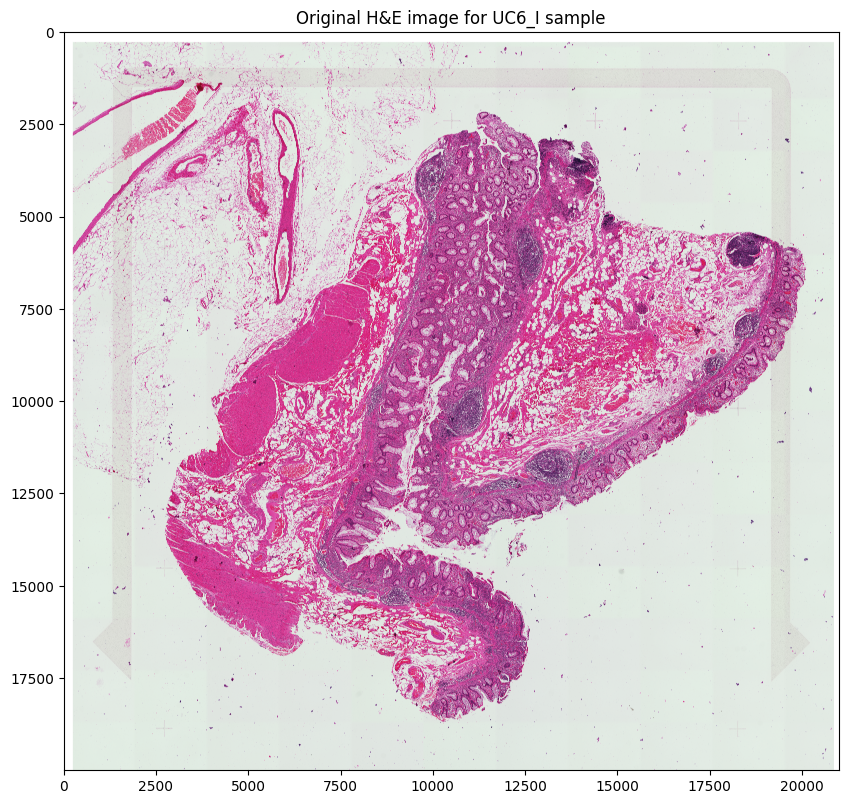

In [ ]:
plt.figure(figsize=(10, 10))
transpose_image = np.transpose(sdata.images['HE_original'].to_numpy(), (1, 2, 0))
plt.imshow(transpose_image)
plt.title("Original H&E image for UC6_I sample")
plt.show()

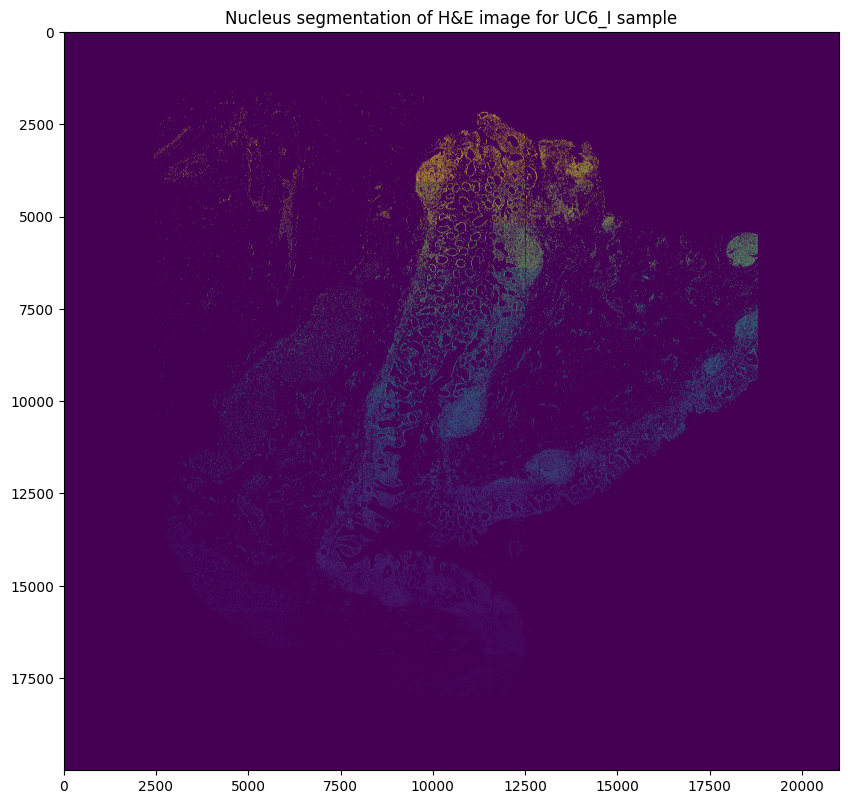

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(sdata.images['HE_nuc_original'].to_numpy()[0,:,:])
plt.title("Nucleus segmentation of H&E image for UC6_I sample")
plt.show()

### Generate summary statistics original H&E image and H&E image overlaid with nucleus annotations

In [ ]:
mean_val = transpose_image.mean().item()
max_val = transpose_image.min().item()
min_val = transpose_image.max().item()
dtype_val = transpose_image.dtype

print("Statistics for 'HE_original'")
print(f"Mean: {mean_val}")
print(f"Min: {min_val}")
print(f"Max: {max_val}")
print(f"Data type: {dtype_val}")

Statistics for 'HE_original'
Mean: 7457.381393981041
Min: 431986
Max: 0
Data type: uint32


In [127]:
mean_val = transpose_image.mean().item()
min_val = transpose_image.min().item()
max_val = transpose_image.max().item()
dtype_val = transpose_image.dtype

print("Statistics for 'HE_nuc_original'")
print(f"Mean: {mean_val}")
print(f"Min: {min_val}")
print(f"Max: {max_val}")
print(f"Data type: {dtype_val}")

Statistics for 'HE_nuc_original'
Mean: 201.75854769832952
Min: 13
Max: 255
Data type: uint8


In [ ]:
print("Image resolution is",transpose_image.shape[0]*transpose_image.shape[1], "pixels")

Image resolution is 419840000 pixels


### Visualize RGB channel distributions

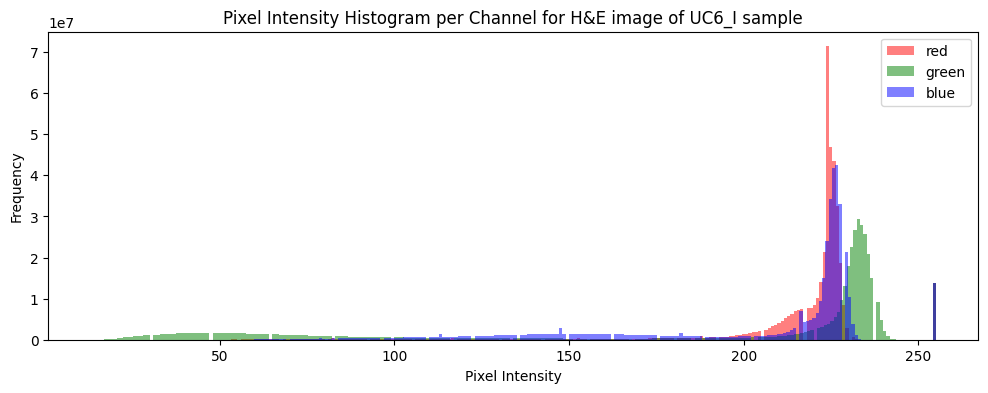

In [ ]:
colors = ['red', 'green', 'blue']
plt.figure(figsize=(12, 4))

for i in range(3):
    plt.hist(sdata.images['HE_original'][i].values.flatten(), bins=256, alpha=0.5, label=colors[i], color=colors[i])

plt.title("Pixel Intensity Histogram per Channel for H&E image of UC6_I sample")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Explore spatial transcriptomics data

In [ ]:
print(sdata.tables["anucleus"].layers["counts"].shape)
print(sdata.tables["anucleus"].layers["counts"])

(223790, 460)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 2 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [3 0 4 ... 0 0 0]]


### Visualize distribution of total gene counts in cells

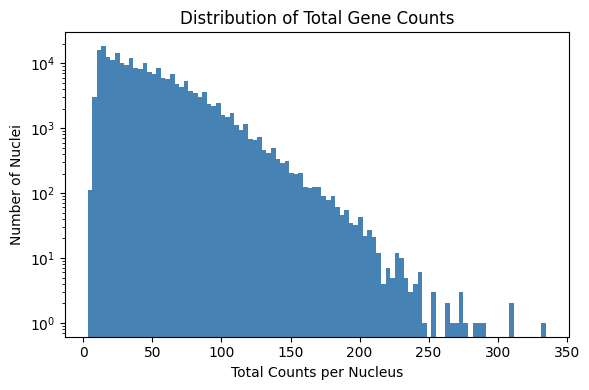

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import issparse

counts = sdata.tables["anucleus"].layers["counts"]

# sum for each gene
total_counts = counts.sum(axis=1)

plt.figure(figsize=(6, 4))
plt.hist(total_counts, bins=100, color="steelblue")
plt.xlabel("Total Counts per Nucleus")
plt.ylabel("Number of Nuclei")
plt.title("Distribution of Total Gene Counts")
plt.yscale("log")
plt.tight_layout()
plt.show()


### Visualize top 20 highly expressed genes

<ipython-input-51-978c8f0194f9>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.xticks(range(20), var_names[top_genes_idx], rotation=45)


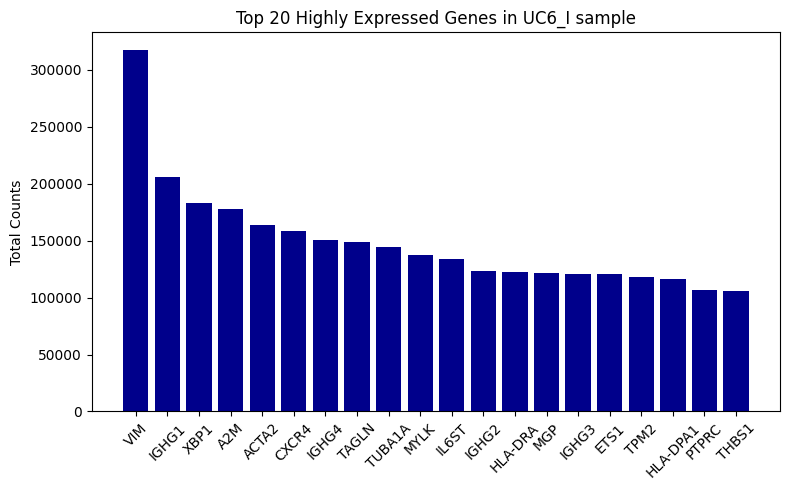

In [ ]:
gene_sums = sdata.sum(axis=0)
var_names = sdata.tables["anucleus"].var["gene_symbols"]
top_genes_idx = np.argsort(gene_sums)[-20:][::-1]

plt.figure(figsize=(8, 5))
plt.bar(range(20), gene_sums[top_genes_idx], color="darkblue")
plt.xticks(range(20), var_names[top_genes_idx], rotation=45)
plt.ylabel("Total Counts")
plt.title("Top 20 Highly Expressed Genes in UC6_I sample")
plt.tight_layout()
plt.show()

### Generate summary statistics for spatial transcriptomics data

In [ ]:
from scipy.sparse import issparse

counts = sdata.tables["anucleus"].layers["counts"]

if issparse(counts):
    mean_val = counts.mean()
    max_val = counts.max()
    min_val = counts.min()
    dtype_val = counts.dtype
else:
    mean_val = np.mean(counts)
    max_val = np.max(counts)
    min_val = np.min(counts)
    dtype_val = counts.dtype

# Display
print("Stats for anucleus.layers['counts']:")
print(f"Mean: {mean_val}")
print(f"Min: {min_val}")
print(f"Max: {max_val}")
print(f"Data type: {dtype_val}")

Stats for anucleus.layers['counts']:
Mean: 0.0995048055533429
Min: 0
Max: 43
Data type: int64


## Data Analysis - Spatial Transcriptomics Data

We analyze the spatial transcriptomics data to get clearer sense of the data. In order to define the "state" of the tissue/(group of) cells, we wanted to experiment with running gene set enrichment analysis (GSEA).

There are two versions of GSEA. Single-sample GSEA, which relies on ranking of the gene expression levels within a sample. GSEA, which relies on ranking of the genes based on differential expression analysis, thereby only using genes that are differentially expressed and therefore are biologically significant.

Here, for the initial exploration, we want to compare the slide-level GSEA to experiment with utilizing GSEA packages.

### Data Loading and Preprocessing

Here we use UC6_I. UC6_I is a colon sample from a patient with ulcerative colitis.

Ulcerative colitis (UC) involves several gene set pathways related to inflammation, immune responses, and cell interactions. Key pathways include cytokine signaling, chemokine signaling, and NF-kB signaling, which are central to regulating inflammatory responses.

From previous literature,
* KEGG_CELL_ADHESION_MOLECULES_CAMS
* KEGG_CHEMOKIND_SIGNALING_PATHWAY
* KEGG_COMPLEMENT_AND_COAGULATION_CASCADES
* KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION
* KEGG_HEMATOPOIETIC_CELL_LINEAGE

were found to be enriched in UC samples.

Reference found here: https://hereditasjournal.biomedcentral.com/articles/10.1186/s41065-022-00259-4

### Using Gene Set Enrichment Analysis Python package (gseapy)

In [ ]:
import gseapy as gp

In [ ]:
sdata.tables["anucleus"].layers["counts"]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [3, 0, 4, ..., 0, 0, 0]])

We then create a pandas dataframe of the expression data.

In [ ]:
# Get gene symbols and expression data
gene_symbols = sdata.tables["anucleus"].var.index.tolist()
expression_data = sdata.tables["anucleus"].X  # No need to convert, it's already a dense array

# Create a pandas DataFrame for expression data
expression_df = pd.DataFrame(expression_data, index=sdata.tables["anucleus"].obs.index, columns=gene_symbols) # This is cell by gene
expression_df = expression_df.T # this is gene by cell (gene = row, cell = column)
expression_df

92   93        94   95        97   98       101       104  \
A2M       0.0  0.0  1.578185  0.0  0.000000  0.0  0.000000  0.000000   
ACP5      0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000   
ACTA2     0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000   
ADAMTSL3  0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000   
AFAP1L2   0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000   
...       ...  ...       ...  ...       ...  ...       ...       ...   
WFDC2     0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000   
XBP1      0.0  0.0  1.578185  0.0  1.941637  0.0  2.162438  0.000000   
XCL2      0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000   
XCR1      0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  0.000000   
ZEB2      0.0  0.0  0.000000  0.0  0.000000  0.0  0.000000  1.791759   

               107       109  ...    431942    431945    431946    431948  \
A2M       1.791759  2.662588  ...  2.036882  1.676690  2.233592  0.000000   
ACP5      0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
ACTA2     0.000000  0.000000  ...  2.036882  0.625706  2.871680  2.311635   
ADAMTSL3  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
AFAP1L2   0.000000  0.000000  ...  0.000000  0.625706  0.000000  0.000000   
...            ...       ...  ...       ...       ...       ...       ...   
WFDC2     0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
XBP1      3.044523  0.000000  ...  0.000000  1.283346  0.000000  0.000000   
XCL2      0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
XCR1      0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
ZEB2      0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   

            431949    431952    431960    431961  431963    431986  
A2M       0.000000  0.000000  2.129113  0.000000     0.0  2.209165  
ACP5      0.000000  0.000000  0.000000  0.000000     0.0  0.000000  
ACTA2     2.311635  2.871680  2.494123  2.796343     0.0  2.469015  
ADAMTSL3  0.000000  0.000000  0.000000  0.000000     0.0  0.000000  
AFAP1L2   0.000000  0.000000  0.000000  0.000000     0.0  0.000000  
...            ...       ...       ...       ...     ...       ...  
WFDC2     0.000000  0.000000  0.000000  0.000000     0.0  0.000000  
XBP1      0.000000  0.000000  0.000000  0.000000     0.0  1.309063  
XCL2      0.000000  0.000000  0.000000  0.000000     0.0  0.000000  
XCR1      0.000000  0.000000  0.000000  0.000000     0.0  0.000000  
ZEB2      0.000000  1.329136  1.548350  0.000000     0.0  0.000000  

[460 rows x 223790 columns]

We then aggregate the expression to produce "bulk" gene expression data.

In [ ]:
# As GSEA relies on the gene rank, we do not need to be concerned with normalization method.
bulk_expression_df = expression_df.sum(axis=1)
bulk_expression_df

A2M         117657.992188
ACP5          6357.807617
ACTA2        88989.789062
ADAMTSL3     14472.334961
AFAP1L2      12788.140625
                ...      
WFDC2         2096.456543
XBP1        123553.046875
XCL2          1226.100830
XCR1          1061.398315
ZEB2         65091.804688
Length: 460, dtype: float32

In [ ]:
# Run ssGSEA
bulk_ssgsea_results = gp.ssgsea(data = bulk_expression_df,
                           gene_sets='/content/drive/MyDrive/209B/h.all.v2024.1.Hs.symbols.gmt',
                           outdir=None,
                           sample_norm_method='rank',  # Choose normalization method
                           threads=4,  # Number of processes for parallelization
                           format='png')  # Output format (optional)

In [ ]:
bulk_ssgsea_results.res2d

Name                                        Term         ES       NES
0   sample1  HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION  97.657756  1.031342
1   sample1                          HALLMARK_APOPTOSIS  89.936935  0.949805
2   sample1             HALLMARK_ESTROGEN_RESPONSE_LATE  87.011228  0.918907
3   sample1                  HALLMARK_KRAS_SIGNALING_UP  74.805163  0.790001
4   sample1            HALLMARK_IL6_JAK_STAT3_SIGNALING  62.727551  0.662452
5   sample1                         HALLMARK_COMPLEMENT    62.2494  0.657402
6   sample1            HALLMARK_TNFA_SIGNALING_VIA_NFKB  61.295684   0.64733
7   sample1          HALLMARK_INTERFERON_GAMMA_RESPONSE  43.638672  0.460859
8   sample1                HALLMARK_IL2_STAT5_SIGNALING  39.609746   0.41831
9   sample1                HALLMARK_ALLOGRAFT_REJECTION  10.318225  0.108969
10  sample1              HALLMARK_INFLAMMATORY_RESPONSE   2.967817  0.031342

https://pubmed.ncbi.nlm.nih.gov/30520951/

According to this paper: "Intestinal fibrosis is an inevitable complication in patients with inflammatory bowel disease [IBD], occurring in its two major clinical manifestations: ulcerative colitis and Crohn's disease. Fibrosis represents the final outcome of the host reaction to persistent inflammation, which triggers a prolonged wound healing response resulting in the excessive deposition of extracellular matrix, eventually leading to intestinal dysfunction. The process of epithelial-to-mesenchymal transition [EMT] represents an embryonic program relaunched during wound healing, fibrosis and cancer."

However, the low expression of genes associated with HALLMARK_INFLAMMATORY_RESPONSE should be further investigated.

** Note that there are only 10 gene sets for which the enrichment score was performed. This due to there being not enough number of genes in the expression matrix that overlap with the gene set genes. This is understandable because we are only using 460 genes here.

### Let's find other gene sets that are relevant!

We can use the MSigDB portal to look for relevant gene sets! Some gene sets I have identified are:
* HP_ULCERATIVE_COLITIS
* WP_ULCERATIVE_COLITIS_SIGNALING

Other than these, there are many gene sets that represent canonical pathways from the KEGG collection. Therefore, I will also use "KEGG_MEDICUS subset of CP" and "KEGG_LEGACY subset of CP".

In [ ]:
# Run ssGSEA
bulk_ssgsea_results = gp.ssgsea(data = bulk_expression_df,
                           gene_sets=['/content/drive/MyDrive/209B/h.all.v2024.1.Hs.symbols.gmt',
                                      '/content/drive/MyDrive/209B/c2.cp.kegg_legacy.v2024.1.Hs.symbols.gmt',
                                      '/content/drive/MyDrive/209B/c2.cp.kegg_medicus.v2024.1.Hs.symbols.gmt',
                                      '/content/drive/MyDrive/209B/HP_ULCERATIVE_COLITIS.v2024.1.Hs.gmt',
                                      '/content/drive/MyDrive/209B/WP_ULCERATIVE_COLITIS_SIGNALING.v2024.1.Hs.gmt'],
                           outdir=None,
                           sample_norm_method='rank',  # Choose normalization method
                           threads=4,  # Number of processes for parallelization
                           format='png')  # Output format (optional)

In [ ]:
gs_all = bulk_ssgsea_results.res2d.sort_values(by='ES', ascending=False)
gs_all["Term"] = gs_all["Term"].str.split(".gmt__").str[1]
gs_all.head(20)

Name                                               Term         ES  \
0   sample1         HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION  97.657756   
1   sample1                                 HALLMARK_APOPTOSIS  89.936935   
2   sample1                    HALLMARK_ESTROGEN_RESPONSE_LATE  87.011228   
3   sample1                            KEGG_PATHWAYS_IN_CANCER  86.213849   
4   sample1                         HALLMARK_KRAS_SIGNALING_UP  74.805163   
5   sample1                          KEGG_LEISHMANIA_INFECTION  64.759176   
6   sample1                   HALLMARK_IL6_JAK_STAT3_SIGNALING  62.727551   
7   sample1                                HALLMARK_COMPLEMENT    62.2494   
8   sample1                   HALLMARK_TNFA_SIGNALING_VIA_NFKB  61.295684   
9   sample1                  KEGG_CELL_ADHESION_MOLECULES_CAMS  60.967771   
10  sample1  KEGG_INTESTINAL_IMMUNE_NETWORK_FOR_IGA_PRODUCTION  59.528133   
11  sample1                    KEGG_HEMATOPOIETIC_CELL_LINEAGE  51.481485   
13  sample1                 HALLMARK_INTERFERON_GAMMA_RESPONSE  43.638672   
14  sample1                       HALLMARK_IL2_STAT5_SIGNALING  39.609746   
15  sample1             KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY  32.188876   
18  sample1                       HALLMARK_ALLOGRAFT_REJECTION  10.318225   
20  sample1                    KEGG_JAK_STAT_SIGNALING_PATHWAY   4.894217   
21  sample1                     HALLMARK_INFLAMMATORY_RESPONSE   2.967817   
19  sample1  KEGG_MEDICUS_REFERENCE_CYTOKINE_JAK_STAT_SIGNA...  -8.924828   
17  sample1           KEGG_NOD_LIKE_RECEPTOR_SIGNALING_PATHWAY -16.332504   

         NES  
0   0.681953  
1   0.628038  
2   0.607608  
3   0.602039  
4   0.522371  
5   0.452219  
6   0.438032  
7   0.434693  
8   0.428034  
9   0.425744  
10  0.415691  
11    0.3595  
13  0.304733  
14  0.276599  
15  0.224778  
18  0.072053  
20  0.034177  
21  0.020725  
19 -0.062323  
17 -0.114051

### We are losing resolution. Let's be a bit more granular.

We know from various literatures that, due to the sparsity of the expression in single cell RNA-seq data, the result of performing ssGSEA is not reliable. This is driven by the presence of genes that share the same expression level (count = 0). Therefore, here I will attempt to perform clustering of the genes based on the expression profile of 460 genes. Then, we will aggregate gene expression profile of cells per cluster. Also, it is more meaningful as we can inspect where "similar" cells (that belong to the same cluster) or "dissimilar cells" (that belong to different clusters) are distributed on the slides.

### Scanpy!

### Projecting the cell clusters onto the WSI
While we have clustered the cells, it would be interesting to see whether the "similar" group of cells are located in close proximity to other cells.

Therefore, we aim to project the cells that we have clustered back onto the H&E whole slide image. This will give us an idea of how cells of similar/dissimilar characteristics are distributed across the entire image.

This can provide us an insight into even how potentially different types(clusters) of cells interact spatially. Given the list of pixels that mask the cell location, we will use the centroid of the pixel coordinates to plot the cell.

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:36)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:07:25)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:03:35)


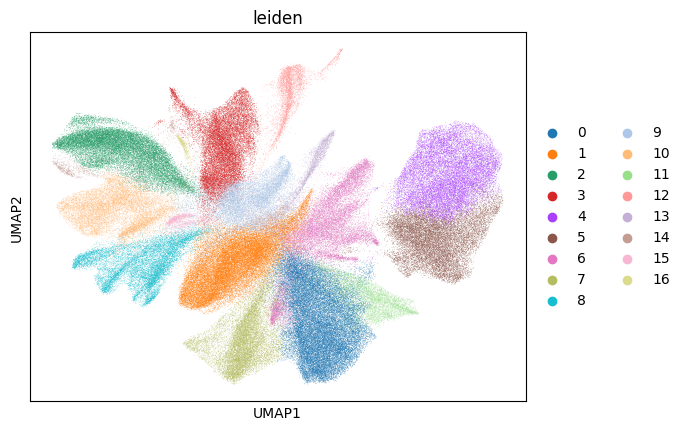

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:19)


/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: 

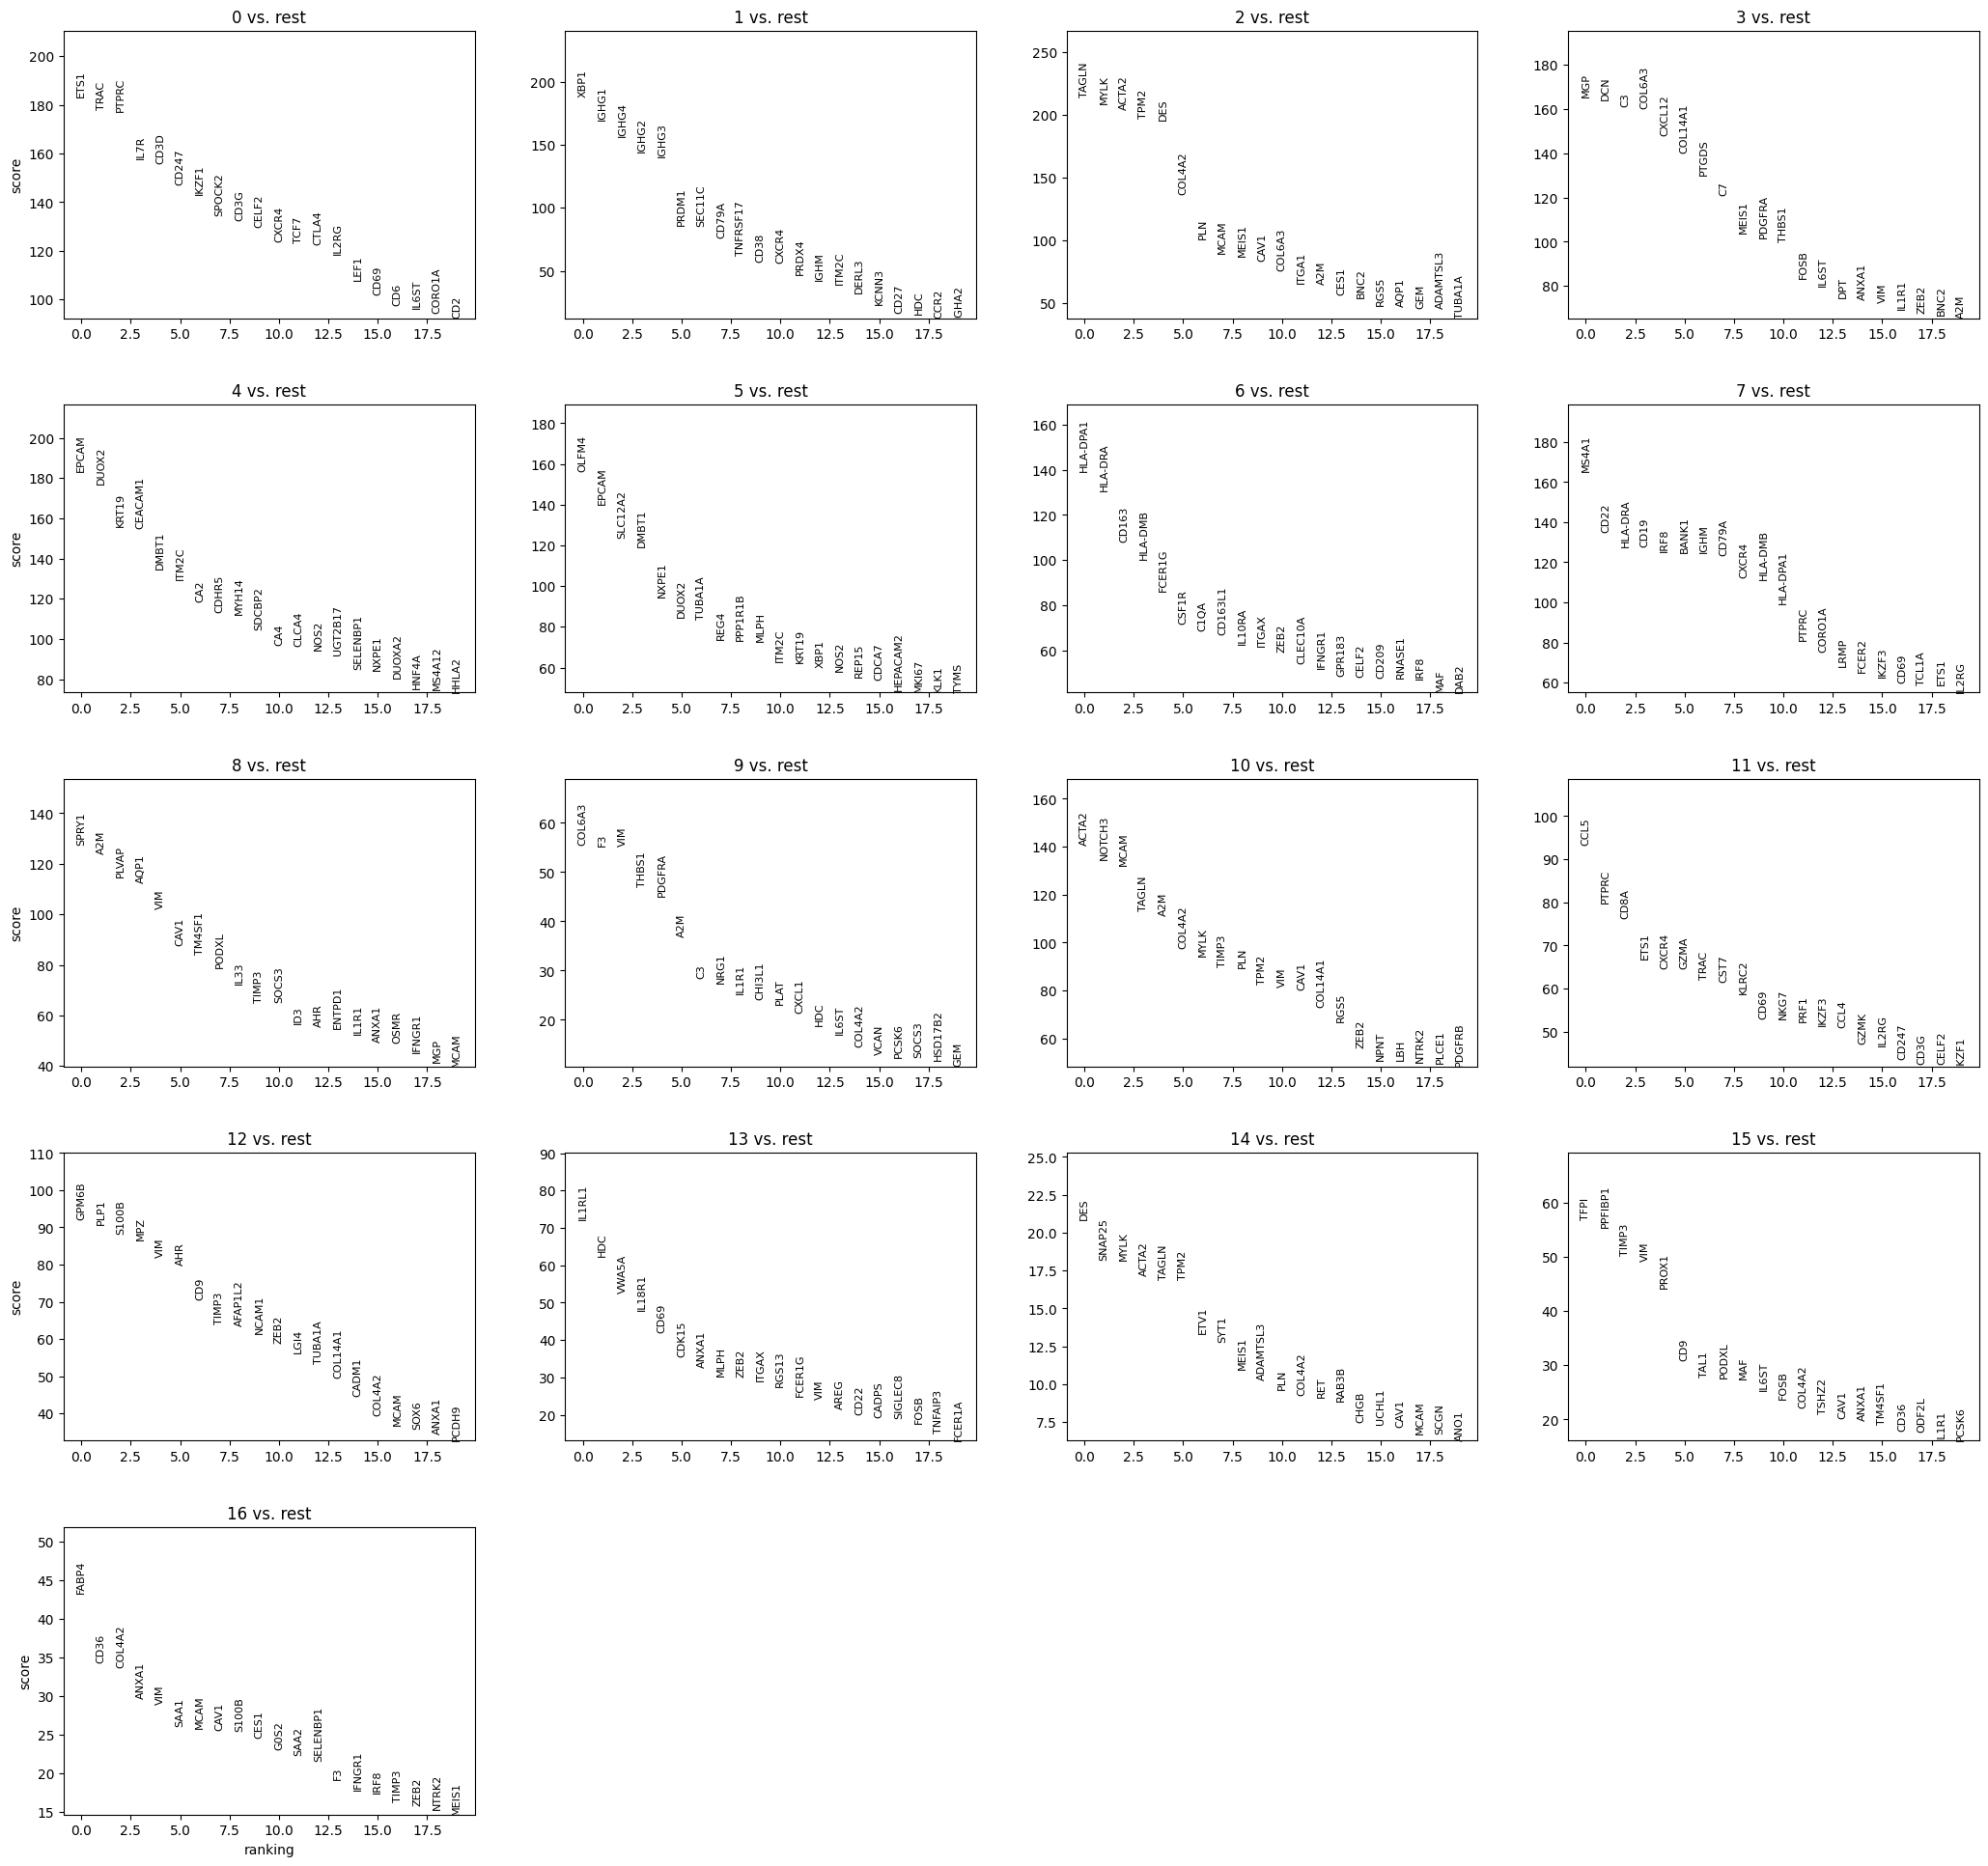

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
from tqdm import tqdm

# Set Scanpy verbosity higher
sc.settings.verbosity = 3  # show more detailed output

# Get gene symbols and expression data
gene_symbols = sdata.tables["anucleus"].var.index.tolist()
expression_data = sdata.tables["anucleus"].layers["counts"]

# Create a pandas DataFrame for expression data
expression_df = pd.DataFrame(expression_data, index=sdata.tables["anucleus"].obs.index, columns=gene_symbols)

# Create AnnData object
adata = sc.AnnData(expression_df.values)
adata.obs.index = sdata.tables["anucleus"].obs.index  # Make sure obs names are correct
adata.var_names = gene_symbols

# Normalize, log-transform, scale
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata)

# PCA
sc.tl.pca(adata, svd_solver='arpack')

# Neighbor graph
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

# Clustering
sc.tl.leiden(adata, resolution=0.5, key_added = 'leiden_0.5')

# UMAP
sc.tl.umap(adata)
sc.pl.umap(adata, color=['leiden_0.5'])  # Visualize in UMAP space

# Marker genes
sc.tl.rank_genes_groups(adata, 'leiden_0.5', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

Using the resolution of 0.5 generated 17 clusters, which may be an overkill. Based on literature, the number of cells that are distinguishable through H&E are 5~8 categories. Hence, we will rerun the analysis by increasing the n_neighbors parameter and lowering the resolution to obtain less granular sub-class.

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:04:58)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:26:32)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:07:38)


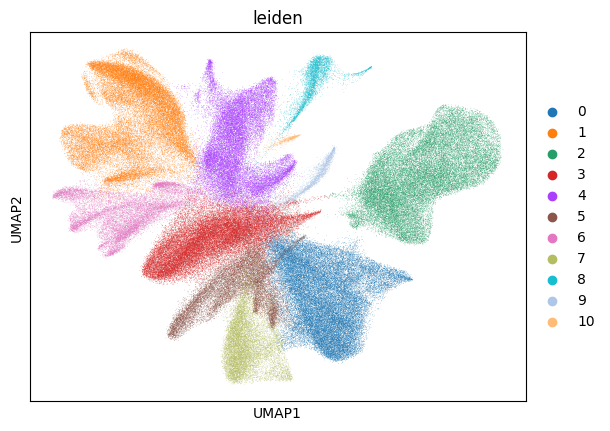

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)


/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: 

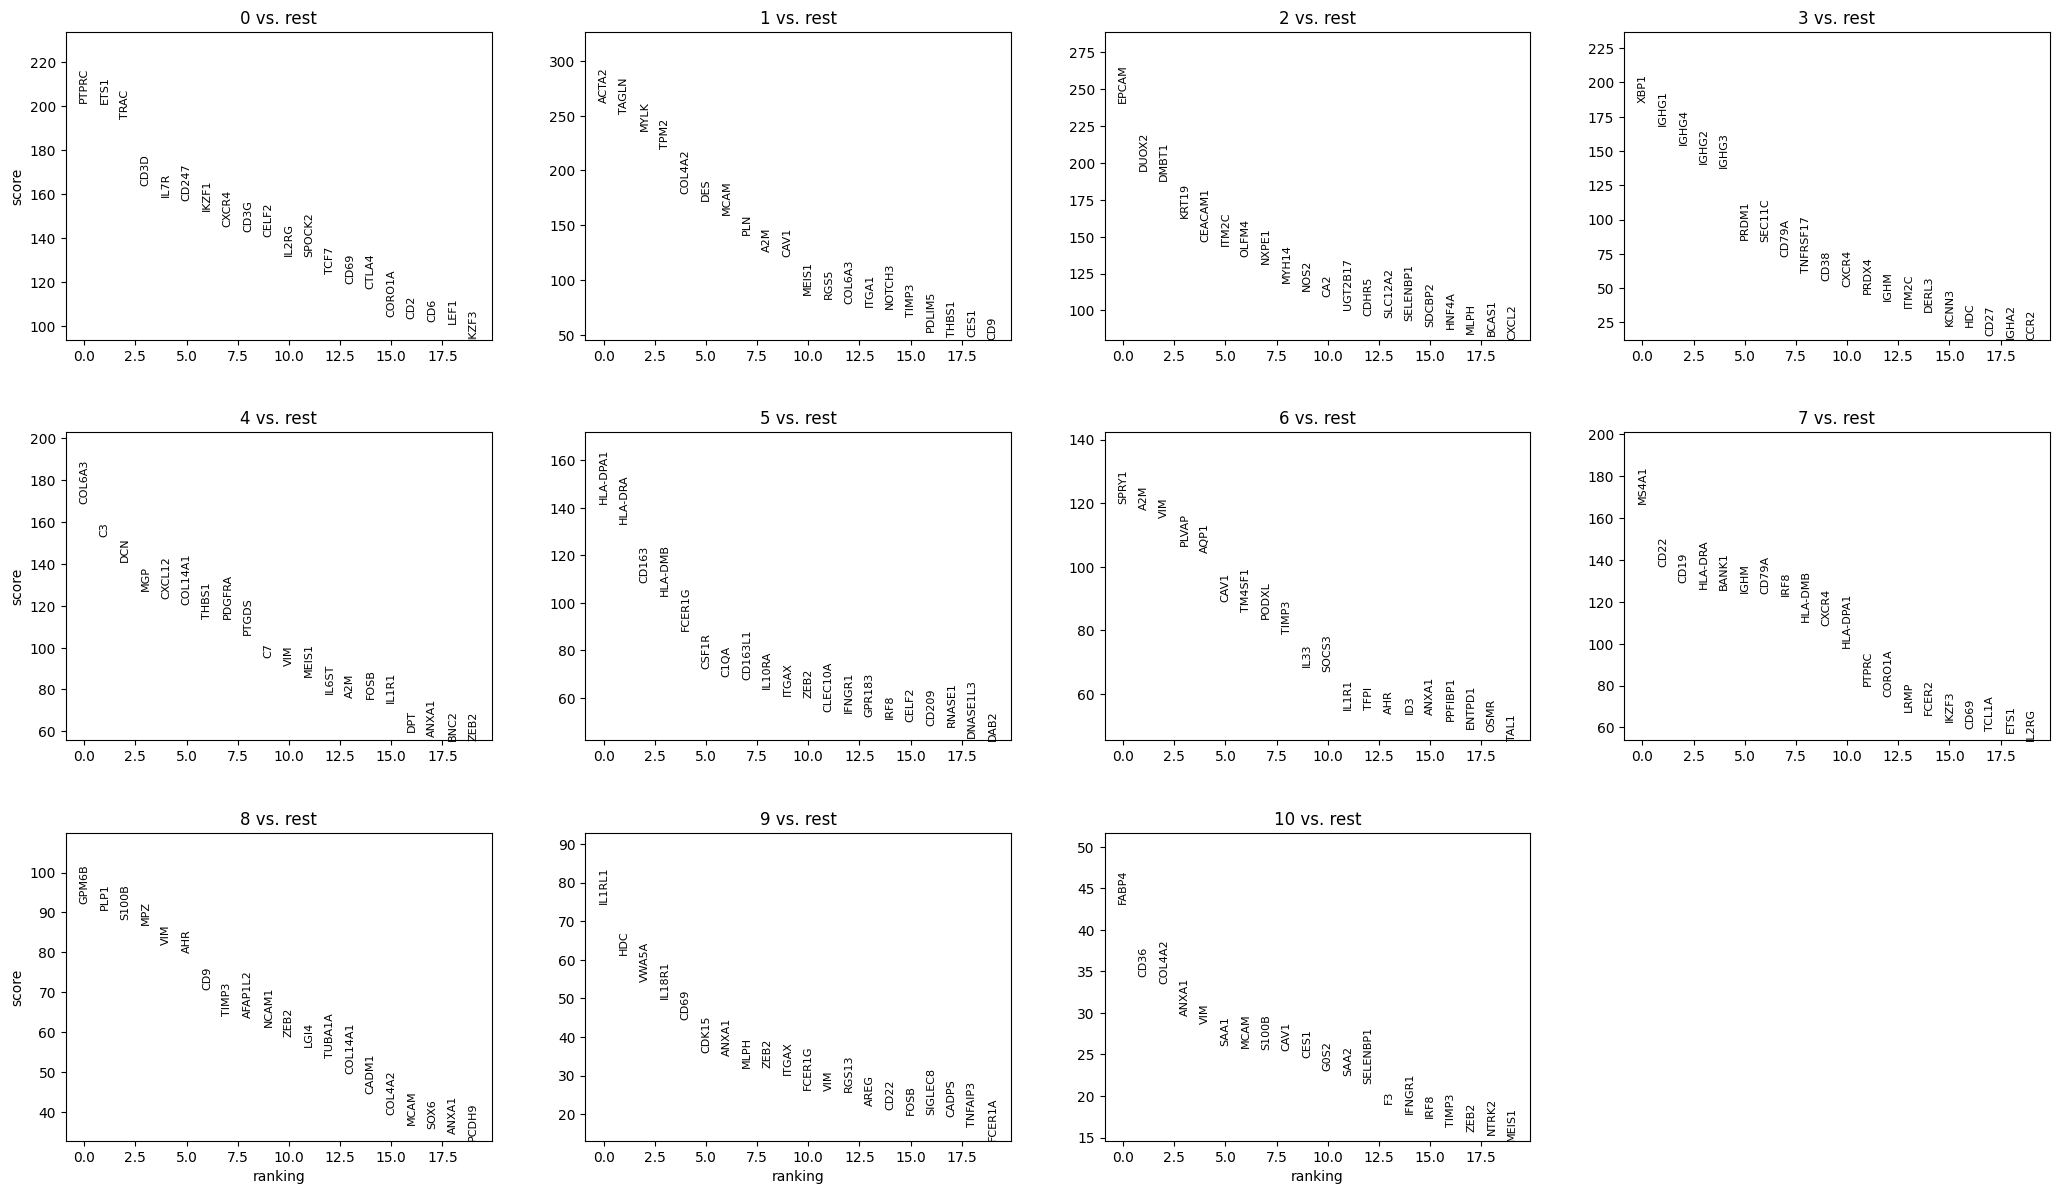

In [ ]:
# Neighbor graph
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=30)

# Clustering
sc.tl.leiden(adata, resolution=0.2, key_added='leiden_0.2')

# UMAP
sc.tl.umap(adata)
sc.pl.umap(adata, color=['leiden_0.2'])  # Visualize in UMAP space

# Marker genes
sc.tl.rank_genes_groups(adata, 'leiden_0.2', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [ ]:
# This is the script that includes mapping to the slides. As this takes a long time (~1 day),
# we will run this script on O2, generate and save the sdata. The saved sdata
# will be used for further analysis.

import numpy as np
import pandas as pd
from joblib import Parallel, delayed

# Get the label mask
label_mask = sdata.images["HE_nuc_original"].to_numpy()[0, :, :]

# Get all unique cell labels (excluding background 0 if necessary)
cell_labels = np.unique(label_mask)
cell_labels = cell_labels[cell_labels != 0]  # if 0 is background

# Define centroid function
def compute_centroid(cell_label):
    y_pixels, x_pixels = np.where(label_mask == cell_label)
    centroid_x = np.mean(x_pixels)
    centroid_y = np.mean(y_pixels)
    return cell_label, centroid_x, centroid_y

# Parallel processing
results = Parallel(n_jobs=-1, verbose=5)(delayed(compute_centroid)(cell_label) for cell_label in cell_labels)

# Unpack results
cell_id_list, centroid_x_list, centroid_y_list = zip(*results)

# Create DataFrame
centroid_df = pd.DataFrame({
    'cell_id': cell_id_list,
    'x': centroid_x_list,
    'y': centroid_y_list
})

In [ ]:
# Get gene symbols and expression data
gene_symbols = sdata.tables["anucleus"].var.index.tolist()
expression_data = sdata.tables["anucleus"].layers["counts"]

# Create a pandas DataFrame for expression data
expression_df = pd.DataFrame(expression_data, index=sdata.tables["anucleus"].obs.index, columns=gene_symbols)
adata = sc.AnnData(expression_df.values)

adata.obs["cell_id"] = sdata.tables["anucleus"].obs
adata.obs["x"] = centroid_df["x"]
adata.obs["y"] = centroid_df["y"]
adata.var_names = gene_symbols

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata)

# PCA
sc.tl.pca(adata, svd_solver='arpack')

# Neighbor graph
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

# Clustering
sc.tl.leiden(adata, resolution=0.5)  # or sc.tl.louvain()

# UMAP (optional)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['leiden'])

# Spatial plot
plt.figure(figsize=(8, 8))
scatter = plt.scatter(adata.obs['x'], adata.obs['y'],
                      c=adata.obs['leiden'].astype(int),
                      cmap='tab20', s=10)
plt.gca().invert_yaxis()
plt.colorbar(scatter)
plt.title('Spatial Clusters')
plt.show()

# Marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

### For what genes are predicting the expression level?

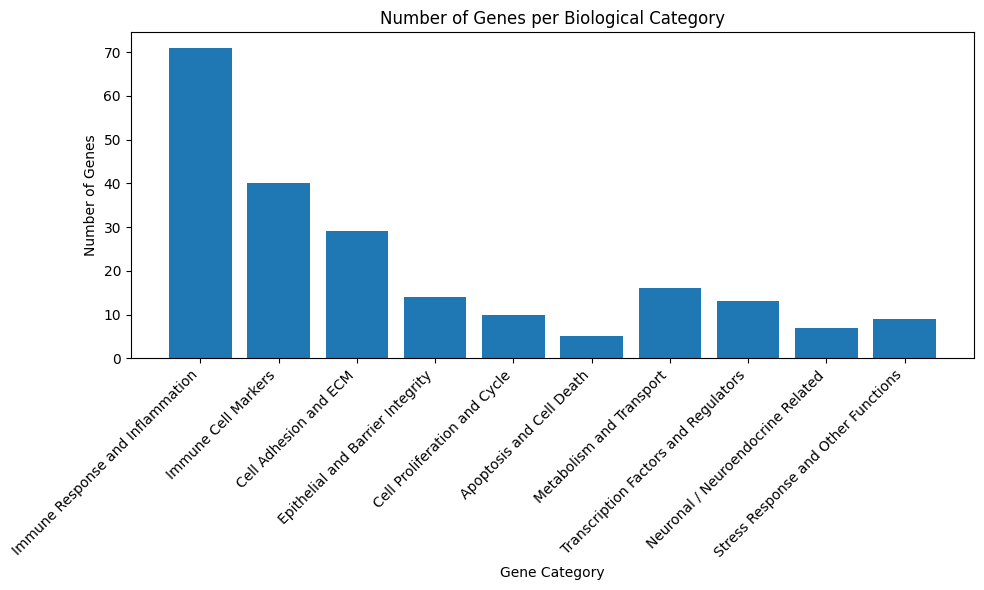

In [ ]:
import matplotlib.pyplot as plt

genes = sdata.tables["anucleus"].var.index.tolist()

# These categories are based on ChatGPT. We only need a general sense of what the
# gene function is. This will provide another layer of interpretability for our model.
gene_categories = {
    "Immune Response and Inflammation": [
        'CCL1', 'CCL2', 'CCL3L1', 'CCL4', 'CCL5', 'CCL7', 'CCL8', 'CCL11', 'CCL13', 'CCL19',
        'CCL20', 'CCL22', 'CCL23', 'CCL24', 'CXCL1', 'CXCL2', 'CXCL3', 'CXCL5', 'CXCL6',
        'CXCL10', 'CXCL11', 'CXCL12', 'CXCL13', 'IL2', 'IL4I1', 'IL5', 'IL5RA', 'IL6', 'IL6R',
        'IL6ST', 'IL7R', 'IL9', 'IL10', 'IL10RA', 'IL10RB', 'IL11', 'IL11RA', 'IL12A', 'IL12B',
        'IL12RB1', 'IL12RB2', 'IL15', 'IL17A', 'IL17RA', 'IL17RC', 'IL17REL', 'IL18', 'IL18R1',
        'IL18RAP', 'IL21', 'IL21R', 'IL22RA1', 'IL23A', 'IL23R', 'IL27RA', 'TNF', 'TNFAIP3',
        'TNFRSF14', 'TNFRSF17', 'TNFSF13B', 'TNFSF14', 'IFNG', 'IFIH1', 'IFNGR1', 'IFNGR2',
        'ISG15', 'C1QA', 'C1QC', 'C3', 'C7', 'FCN1'
    ],
    "Immune Cell Markers": [
        'CD2', 'CD3D', 'CD3G', 'CD4', 'CD5', 'CD6', 'CD7', 'CD8A', 'CD8B', 'TRAC', 'TRDC', 'ICOS',
        'CTLA4', 'PDCD1', 'TIGIT', 'CD19', 'CD22', 'CD79A', 'MS4A1', 'FCRLA', 'CD68', 'CD163',
        'CD163L1', 'CSF1R', 'FCGR3A', 'FCGR3B', 'CD1C', 'CLEC9A', 'CLEC10A', 'CD209', 'KLRB1',
        'KLRC2', 'KLRD1', 'NKG7', 'SELL', 'LST1', 'SIGLEC8', 'HLA-DMB', 'HLA-DPA1', 'HLA-DRA'
    ],
    "Cell Adhesion and ECM": [
        'ITGA1', 'ITGAX', 'MCAM', 'VCAM1', 'VIM', 'TAGLN', 'COL14A1', 'COL4A2', 'COL6A3', 'DCN',
        'ELN', 'MFAP5', 'MGP', 'SPP1', 'THBS1', 'VCAN', 'CAV1', 'CEACAM1', 'CEACAM7', 'ICAM2',
        'ACTA2', 'FNDC1', 'DES', 'S100A4', 'HOPX', 'DPT', 'MMP1', 'MMP3', 'TIMP3'
    ],
    "Epithelial and Barrier Integrity": [
        'EPCAM', 'CDHR5', 'VIL1', 'KRT1', 'KRT19', 'KRT86', 'OLFM4', 'CLCA4', 'CA1', 'CA2', 'CA4',
        'CA7', 'CFTR', 'GUCA2A'
    ],
    "Cell Proliferation and Cycle": [
        'MKI67', 'CDC20', 'CDK1', 'CDK15', 'NUSAP1', 'TOP2A', 'TYMS', 'RRM2', 'UBE2C', 'PTTG1'
    ],
    "Apoptosis and Cell Death": [
        'PRF1', 'GZMA', 'GZMB', 'GZMH', 'GZMK'
    ],
    "Metabolism and Transport": [
        'ALDH1B1', 'SLC12A2', 'FFAR4', 'DUOX2', 'DUOXA2', 'ENTPD1', 'HCAR3', 'HSD17B2', 'PTGDS',
        'PTGIS', 'IDO1', 'COX4I2', 'FABP4', 'PLVAP', 'PLAUR', 'PLAT'
    ],
    "Transcription Factors and Regulators": [
        'BATF', 'FOXP3', 'GATA3', 'ETV1', 'ETS1', 'LEF1', 'SPIB', 'RARA', 'TCF7', 'PRDM1', 'ID2',
        'ID3', 'ZEB2'
    ],
    "Neuronal / Neuroendocrine Related": [
        'SNAP25', 'SYT1', 'CHAT', 'SST', 'SYP', 'PENK', 'NEUROG3'
    ],
    "Stress Response and Other Functions": [
        'S100B', 'S100P', 'S100A4', 'CHI3L1', 'MT1E', 'MT1G', 'MT1M', 'MT1X', 'PRDX4'
    ]
}

category_counts = {category: len(genes_in_cat) for category, genes_in_cat in gene_categories.items()}

plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values())
plt.ylabel('Number of Genes')
plt.xlabel('Gene Category')
plt.title('Number of Genes per Biological Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This information may be helpful as we build and test the model. We can identify for which group of genes we are predicting poorly on. This can motivate biological explanations to the model performance!

### Citation
Broad Institute autoimmune disease. CrunchDAO Docs V3. (2024a). https://docs.crunchdao.com/competitions/competitions/broad-institute-autoimmune-disease

"Can you provide me the categorization of the genes based on their pathway involvement/function? Here are the genes: 'A2M', 'ACP5', 'ACTA2', 'ADAMTSL3', 'AFAP1L2', 'AHR', 'ALDH1B1', 'ANO1', 'ANXA1', 'AQP1', 'AQP8', 'AREG', 'ASCL2', 'ATIC', 'AVIL', 'AXL', 'BANK1', 'BATF', 'BCAS1', 'BMX', 'BNC2', 'BTNL9', 'C1QA', 'C1QC', 'C3', 'C7', 'CA1', 'CA2', 'CA4', 'CA7', 'CADM1', 'CADPS', 'CALCB', 'CARD9', 'CAV1', 'CBLB', 'CCK', 'CCL1', 'CCL11', 'CCL13', 'CCL19', 'CCL2', 'CCL20', 'CCL22', 'CCL23', 'CCL24', 'CCL3L1', 'CCL4', 'CCL5', 'CCL7', 'CCL8', 'CCNB1', 'CCR1', 'CCR2', 'CCR3', 'CCR4', 'CCR5', 'CCR6', 'CCR7', 'CCR8', 'CD163', 'CD163L1', 'CD19', 'CD1C', 'CD2', 'CD209', 'CD22', 'CD247', 'CD27', 'CD300E', 'CD36', 'CD38', 'CD3D', 'CD3G', 'CD4', 'CD40LG', 'CD5', 'CD55', 'CD6', 'CD68', 'CD69', 'CD7', 'CD79A', 'CD83', 'CD86', 'CD8A', 'CD8B', 'CD9', 'CDC20', 'CDCA7', 'CDHR5', 'CDK1', 'CDK15', 'CDKN2B', 'CEACAM1', 'CEACAM7', 'CELF2', 'CES1', 'CES2', 'CFTR', 'CHAT', 'CHGB', 'CHI3L1', 'CLC', 'CLCA4', 'CLEC10A', 'CLEC9A', 'CMTM2', 'CNRIP1', 'COL14A1', 'COL4A2', 'COL6A3', 'CORO1A', 'COX4I2', 'CRTAM', 'CSF1R', 'CSF3', 'CST7', 'CSTA', 'CTLA4', 'CXCL1', 'CXCL10', 'CXCL11', 'CXCL12', 'CXCL13', 'CXCL2', 'CXCL3', 'CXCL5', 'CXCL6', 'CXCR1', 'CXCR2', 'CXCR3', 'CXCR4', 'CXCR5', 'CXCR6', 'DAB2', 'DCN', 'DEFB4A', 'DERL3', 'DES', 'DMBT1', 'DNASE1L3', 'DOK2', 'DPT', 'DUOX2', 'DUOXA2', 'EBI3', 'ELN', 'ENTPD1', 'EP300', 'EPCAM', 'EREG', 'ETS1', 'ETV1', 'F3', 'FABP4', 'FCER1A', 'FCER1G', 'FCER2', 'FCGR3A', 'FCGR3B', 'FCN1', 'FCRLA', 'FFAR4', 'FNDC1', 'FOLR2', 'FOSB', 'FOXP3', 'FRZB', 'G0S2', 'GATA3', 'GEM', 'GIP', 'GJA4', 'GNA11', 'GPC3', 'GPM6B', 'GPR183', 'GPR35', 'GUCA2A', 'GZMA', 'GZMB', 'GZMH', 'GZMK', 'HAPLN1', 'HBEGF', 'HCAR3', 'HDC', 'HEPACAM2', 'HEY1', 'HHLA2', 'HIGD1B', 'HLA-DMB', 'HLA-DPA1', 'HLA-DRA', 'HMGB2', 'HNF4A', 'HOPX', 'HSD17B2', 'ICAM2', 'ICOS', 'ID2', 'ID3', 'IDO1', 'IFIH1', 'IFNG', 'IFNGR1', 'IFNGR2', 'IGFBP6', 'IGHA2', 'IGHG1', 'IGHG2', 'IGHG3', 'IGHG4', 'IGHM', 'IKZF1', 'IKZF3', 'IL10', 'IL10RA', 'IL10RB', 'IL11', 'IL11RA', 'IL12A', 'IL12B', 'IL12RB1', 'IL12RB2', 'IL15', 'IL17A', 'IL17RA', 'IL17RC', 'IL17REL', 'IL18', 'IL18R1', 'IL18RAP', 'IL1R1', 'IL1R2', 'IL1RAP', 'IL1RL1', 'IL2', 'IL21', 'IL21R', 'IL22RA1', 'IL23A', 'IL23R', 'IL27RA', 'IL2RA', 'IL2RB', 'IL2RG', 'IL33', 'IL4I1', 'IL5', 'IL5RA', 'IL6', 'IL6R', 'IL6ST', 'IL7R', 'IL9', 'IMPDH2', 'IRF8', 'ISG15', 'ITGA1', 'ITGAX', 'ITLN2', 'ITM2C', 'KCNIP4', 'KCNN3', 'KLK1', 'KLRB1', 'KLRC2', 'KLRD1', 'KRT1', 'KRT19', 'KRT86', 'LBH', 'LEF1', 'LEFTY1', 'LGALS2', 'LGI4', 'LGR5', 'LRMP', 'LRRK2', 'LST1', 'LTB', 'LY6H', 'MAF', 'MARCKSL1', 'MATK', 'MBP', 'MCAM', 'MEFV', 'MEIS1', 'MFAP5', 'MGP', 'MKI67', 'MLPH', 'MMP1', 'MMP3', 'MPO', 'MPZ', 'MR1', 'MS4A1', 'MS4A12', 'MS4A3', 'MSLN', 'MT1E', 'MT1G', 'MT1M', 'MT1X', 'MYH14', 'MYLK', 'NCAM1', 'NDUFA4L2', 'NEUROG3', 'NKG7', 'NKX2-3', 'NMU', 'NOD2', 'NOS1', 'NOS2', 'NOSIP', 'NOTCH3', 'NOVA1', 'NPNT', 'NRG1', 'NTRK2', 'NUSAP1', 'NXPE1', 'ODF2L', 'OLFM4', 'OSM', 'OSMR', 'P2RY1', 'PCDH9', 'PCNA', 'PCSK6', 'PDCD1', 'PDGFRA', 'PDGFRB', 'PDLIM5', 'PENK', 'PF4', 'PGLYRP1', 'PI16', 'PID1', 'PKIB', 'PLAT', 'PLAUR', 'PLCE1', 'PLN', 'PLP1', 'PLVAP', 'PODXL', 'PPFIBP1', 'PPP1R1B', 'PRDM1', 'PRDX4', 'PRF1', 'PRG2', 'PROK2', 'PROX1', 'PTAFR', 'PTGDS', 'PTGIS', 'PTPN22', 'PTPRC', 'PTTG1', 'RAB3B', 'RANBP1', 'RARA', 'RBFOX1', 'RBP7', 'REG1B', 'REG4', 'REP15', 'RET', 'RETN', 'RGCC', 'RGS13', 'RGS5', 'RNASE1', 'RNASE2', 'RORC', 'RRM2', 'RSPO3', 'S100A4', 'S100B', 'S100P', 'SAA1', 'SAA2', 'SCGN', 'SCMH1', 'SDCBP2', 'SEC11C', 'SELE', 'SELENBP1', 'SELL', 'SEMA3G', 'SGCZ', 'SIGLEC8', 'SLC12A2', 'SLIT2', 'SMIM14', 'SNAP25', 'SNCA', 'SOCS3', 'SOSTDC1', 'SOX6', 'SPIB', 'SPOCK2', 'SPP1', 'SPRY1', 'SST', 'STEAP4', 'STMN1', 'SULT1B1', 'SYP', 'SYT1', 'TAGLN', 'TAL1', 'TCF7', 'TCL1A', 'TFF1', 'TFPI', 'TGFB1', 'THBS1', 'TIGIT', 'TIMP3', 'TK1', 'TM4SF1', 'TNF', 'TNFAIP3', 'TNFRSF14', 'TNFRSF17', 'TNFSF13B', 'TNFSF14', 'TOP2A', 'TPH1', 'TPM2', 'TRAC', 'TRAT1', 'TRDC', 'TSHZ2', 'TSLP', 'TUBA1A', 'TUBB', 'TYMS', 'UBE2C', 'UCHL1', 'UGT2B17', 'VCAM1', 'VCAN', 'VIL1', 'VIM', 'VPREB3', 'VWA5A', 'WFDC2', 'XBP1', 'XCL2', 'XCR1', 'ZEB2'" prompt. ChatGPT 4o, OpenAI, 18 April 2025, chat.openai.com/chat.

## Data Analysis - H&E imaging data

### Finding efficient way to load data

Let's re-load the image data:

In [17]:
path_to_project = "/content/drive/MyDrive/209B"
path_to_data = "UC6_I.zarr/UC6_I.zarr"
# path_to_data = "DC1.zarr/DC1.zarr"
sdata = sd.read_zarr(os.path.join(path_to_project, path_to_data))

In [74]:
sdata

SpatialData object, with associated Zarr store: /content/drive/.shortcut-targets-by-id/1gGIHAbOd2Iz7voASC_n_CSdgasqWWIaI/209B/UC6_I.zarr/UC6_I.zarr
├── Images
│     ├── 'HE_nuc_original': DataArray[cyx] (1, 20000, 20992)
│     └── 'HE_original': DataArray[cyx] (3, 20000, 20992)
└── Tables
      ├── 'anucleus': AnnData (223790, 460)
      └── 'cell_id-group': AnnData (308924, 0)
with coordinate systems:
    ▸ 'global', with elements:
        HE_nuc_original (Images), HE_original (Images)

Clearly this step is taking a lot of time. We need a way to extract the data in a convenient format once and for all and not have to go through the trouble of reloading everything everytime.

First, we need to break our whole slice image data into pieces: an array of size $20000 \times 20992 \times 3$ is too heavy to be stored or handled in a ML pipeline.
This **patchification** process allows us to generate for every whole slice image a dataset containing a multiple patches. Of course, some (or perhaps many) of these patches do not contain any cells, so we will check to what extent this is the case.

Second, we want to save in the same format, the patches corresponding to cell nuclei segmentation.

Third, we'll save a .npy file of the whole slice image, which can be loaded out of RAM (with less computations).

Fourth, we'll save as dataframes the table reporting gene expression profiles in every cell of the image and the table storing the train/test repartition of cell ids across the image.

Here is a proposal organization of the Preprocessed_data folder:

Preprocessed_data   
├── UC6_I folder  
│$\;\;\;\;\;\;$    ├── HD5 file with HE image patches  
│$\;\;\;\;\;\;$    ├── HD5 file with HE nuclei mask patches   
│$\;\;\;\;\;\;$    ├── Whole Slice image in .npy   
│$\;\;\;\;\;\;$    ├── Gene expression profile  
│$\;\;\;\;\;\;$    └── Group repartition  
├── DC1 folder  
│$\;\;\;\;\;\;$    ├── HD5 file with HE image patches  
│$\;\;\;\;\;\;$    ├── HD5 file with HE nuclei mask patches   
│$\;\;\;\;\;\;$    ├── Whole Slice image in .npy   
│$\;\;\;\;\;\;$    ├── Gene expression profile  
│$\;\;\;\;\;\;$    └── Group repartition  
 etc.

 Due to the computational toll of this process, we will implement this process in this notebook for only the whole slice image "UC6_I", but we'll perform the same preprocessing steps for the other slices we have.

In [77]:
path_to_preprocessed_data = "/content/drive/MyDrive/209B/preprocessed_data"
path_to_uc6_i = "/UC6_I"

In [75]:
gene_expression_data = sdata.tables["anucleus"].to_df()
gene_expression_data.to_csv(path_to_preprocessed_data + path_to_uc6_i + "/gene_expression_data.csv")

In [76]:
group_repartition = sdata.tables["cell_id-group"].obs
group_repartition.to_csv(path_to_preprocessed_data + path_to_uc6_i + "/group_repartition.csv")

### Patchification

Let's store the image in a np array.

In [19]:
he_img_arr = sdata.images['HE_original'].to_numpy()
he_img_arr_t = he_img_arr.transpose(1, 2, 0)

In [78]:
np.save(path_to_preprocessed_data + path_to_uc6_i + "/HE_original.npy", he_img_arr_t)

In [20]:
u,v,_= he_img_arr_t.shape
u/32,v/32

(625.0, 656.0)

The image width and length are divisible by 32. This means we can create $32 \times 32 = 1024$ patches in a dataset.

In [21]:
def patchify_he_img(he_img_arr_t, n_patches = 32):
    patches = {}
    stride_i = he_img_arr_t.shape[0] // n_patches
    stride_j = he_img_arr_t.shape[1] // n_patches
    for i in range(0, he_img_arr_t.shape[0], stride_i):
        for j in range(0, he_img_arr_t.shape[1], stride_j):
            patch = he_img_arr_t[i:i+stride_i, j:j+stride_j, :]
            patches[(i, j)] = patch
    return patches

In [22]:
patches = patchify_he_img(he_img_arr_t) #to patchify the whole slice image

In [23]:
segm_mask_arr = sdata.images["HE_nuc_original"].to_numpy()
segm_mask_arr_t = segm_mask_arr.transpose(1, 2, 0)

In [24]:
segm_patches = patchify_he_img(segm_mask_arr_t) #to patchify the segmentation mask image

Then, let's explore how many **distinct** cells we find in each patch with respect to the cell nuclei segmentation mask.

In [25]:
cell_nb_in_patches = {}
for key, patch in segm_patches.items():
    cell_nb = len(np.unique(patch))
    cell_nb_in_patches[key] = cell_nb

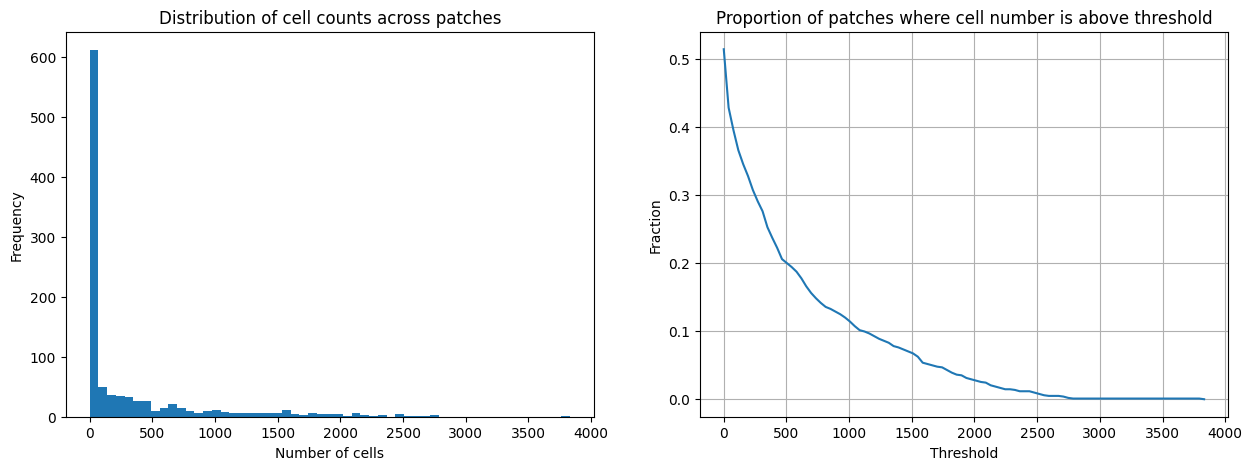

In [26]:
fig, ax = plt.subplots(1,2,figsize=(15, 5))
cell_nb_in_patches_list = list(cell_nb_in_patches.values())
ax[0].hist(cell_nb_in_patches_list, bins="auto")
ax[0].set_title('Distribution of cell counts across patches')
ax[0].set_xlabel('Number of cells')
ax[0].set_ylabel('Frequency')
thr = np.linspace(np.min(cell_nb_in_patches_list), np.max(cell_nb_in_patches_list), 100)
fraction_list = []
for t in thr:
    fraction_list.append(np.sum(np.array(cell_nb_in_patches_list) > t) / len(cell_nb_in_patches_list))
ax[1].plot(thr, fraction_list)
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Fraction')
ax[1].set_title('Proportion of patches where cell number is above threshold')
ax[1].grid()
plt.show()

This step is very informative! Approximately 50% of the patches do not contain any cell! It would be totally useless to store all the patches in the image! Next, let us take a look at different levels of cell population across patches.

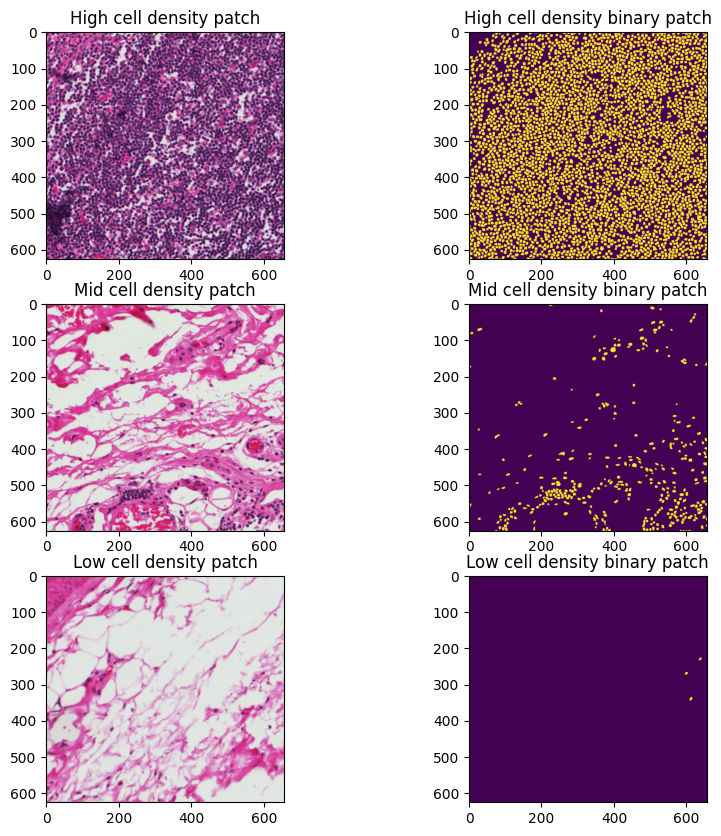

In [27]:
cell_nb_idx_sorted = np.argsort(list(cell_nb_in_patches.values()))
high_cell_density = list(cell_nb_in_patches.keys())[cell_nb_idx_sorted[-1]]
low_cell_density = list(cell_nb_in_patches.keys())[cell_nb_idx_sorted[len(cell_nb_in_patches)//2]]
mid_cell_density = list(cell_nb_in_patches.keys())[cell_nb_idx_sorted[3*len(cell_nb_in_patches)//4]]

fig, ax = plt.subplots(3,2,figsize=(10, 10))
ax[0,0].imshow(patches[high_cell_density])
ax[0,0].set_title('High cell density patch')
ax[0,1].imshow(segm_patches[high_cell_density]>0)
ax[0,1].set_title('High cell density binary patch')

ax[1,0].imshow(patches[mid_cell_density])
ax[1,0].set_title('Mid cell density patch')
ax[1,1].imshow(segm_patches[mid_cell_density]>0)
ax[1,1].set_title('Mid cell density binary patch')

ax[2,0].imshow(patches[low_cell_density])
ax[2,0].set_title('Low cell density patch')
ax[2,1].imshow(segm_patches[low_cell_density]>0)
ax[2,1].set_title('Low cell density binary patch')
plt.show()

In [28]:
non_empty_patches = {}
non_empty_segm_patches = {}
for key, patch in segm_patches.items():
    if np.sum(patch) > 0:
        non_empty_patches[key] = patches[key]
        non_empty_segm_patches[key] = patch
print(f"Number of non-empty patches: {len(non_empty_patches)}")

Number of non-empty patches: 527


Next, we save the patches in HD5 datasets.

In [29]:
def save_patches_to_hd5(patches, filename,path_size):
    with h5py.File(filename, 'w') as f:
        f.attrs['path_size'] = path_size
        for key, patch in tqdm(patches.items()):
            f.create_dataset(f'{key[0]}_{key[1]}', data=patch)
        print(f"Patches saved to {filename}")

In [33]:
save_patches_to_hd5(non_empty_patches, path_to_preprocessed_data + path_to_uc6_i + "/UC6_I_patches.h5",(625,656))
print("HE Image patches dataset saved")
save_patches_to_hd5(non_empty_segm_patches, path_to_preprocessed_data + path_to_uc6_i + "/UC6_I_segm_patches.h5",(625,656))
print("HE Image segmentation patches dataset saved")

100%|██████████| 527/527 [00:14<00:00, 36.10it/s]


Patches saved to /content/drive/MyDrive/209B/preprocessed_data/UC6_I/UC6_I_patches.h5
HE Image patches dataset saved


100%|██████████| 527/527 [00:32<00:00, 16.06it/s]

Patches saved to /content/drive/MyDrive/209B/preprocessed_data/UC6_I/UC6_I_segm_patches.h5
HE Image segmentation patches dataset saved


At this point, we don't need to manipulate this heavy data anymore!

### Analysis of spatial data

In [36]:
he_patches_dataset = h5py.File(path_to_preprocessed_data + path_to_uc6_i + "/UC6_I_patches.h5", 'r')
he_segm_patches_dataset = h5py.File(path_to_preprocessed_data + path_to_uc6_i + "/UC6_I_segm_patches.h5", 'r')

In [80]:
he_array_saved = np.load(path_to_preprocessed_data + path_to_uc6_i + '/HE_original.npy', mmap_mode='r')

First, let us take a look at the patchification output. Which patches did we keep after discarding the empty patches?

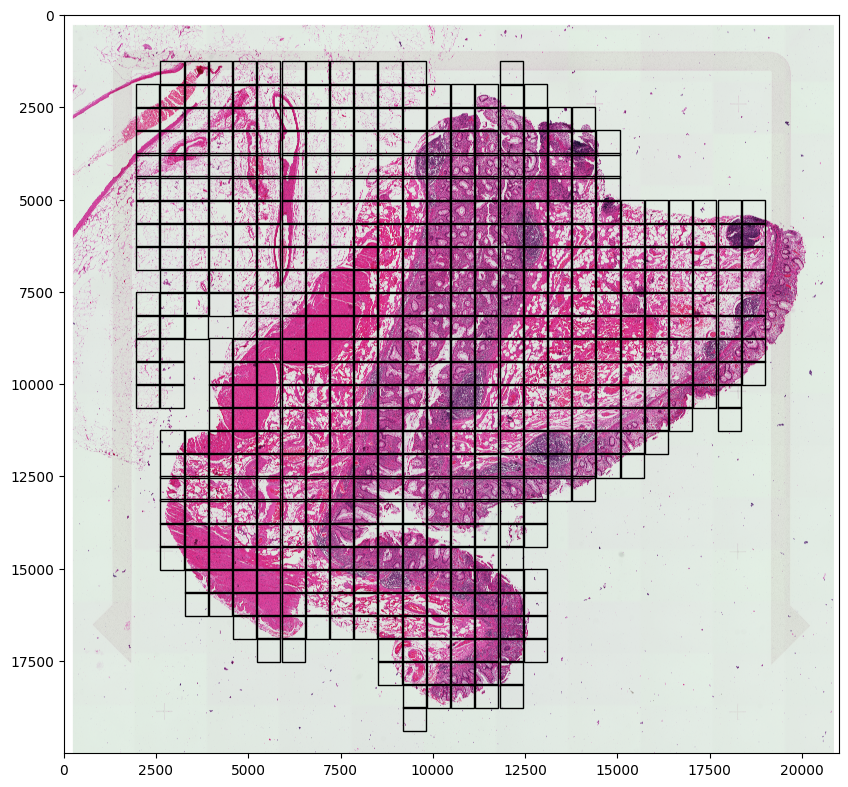

In [82]:
patches_coords = list(he_patches_dataset.keys())
u,v = 625,656

plt.figure(figsize=(10, 10))
plt.imshow(he_array_saved)
for patch_coord in patches_coords:
    coord = tuple(map(int, patch_coord.split('_')))
    #draw a black square with size (u,v)
    plt.gca().add_patch(Rectangle((coord[1], coord[0]), u, v, fill=False, edgecolor='black', linewidth=1))

plt.show()

The output of the patchification step makes sense and overall overlaps with the tissue layout on the whole slice image. Next, we could wonder, how uniformly distributed the cells are across patches.

In [37]:
counts = {coord: len(np.unique(he_segm_patches_dataset[coord])) for coord in he_patches_dataset.keys()}
counts_values = list(counts.values())

In [38]:
img_length_shorter,img_width_shorter = 20000//625,20992//656
temp = np.zeros((img_length_shorter,img_width_shorter))
for coord in he_patches_dataset.keys():
    count = counts[coord]
    coord = tuple(map(int, coord.split('_')))
    temp[coord[0]//625,coord[1]//656] = count

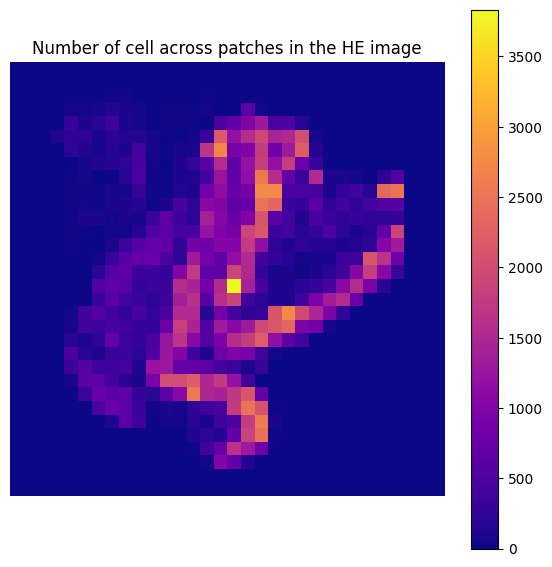

In [39]:
plt.figure(figsize=(7, 7))
plt.imshow(temp,cmap = "plasma")
plt.axis('off')
plt.colorbar()
plt.title("Number of cell across patches in the HE image")
plt.show()

The number of cells across the patches in the H/E stained image vary a lot from one patch to the other. If we want to batch our patches before feeding them into some model, we may want to stratify batches with respect to cell counts. Moreover, these variations follow specific patterns (neighboring patches tend to have more cells), which may be worth tracking through some sort of positional encoding.

## Baseline Model Construction: Resnet50 + FCN

In [156]:
class PatchCells(Dataset):
    """
    This class takes in an histology image, 
    list of cell ids that is supposedly in that image
    a dictionary that maps cell ids to their centroid coordinates,
    and a patch size. 
    """
    def __init__(self, image, cell_ids, cell_coords, patch_size=32):
        self.image = image
        self.cell_ids = cell_ids
        self.cell_coords = cell_coords
        self.patch_size = patch_size

    # do a filtering of the cell ids
        self.valid_cell_ids = [id for id in cell_ids if id in cell_coords]

    def __len__(self):
        return len(self.valid_cell_ids)
        
    # takes in a cell id, returns a {key: cell id, value: patch in tensor format}
    def __getitem__(self, idx):
        cell_id = self.valid_cell_ids[idx]
        x, y = self.cell_coords[cell_id]

        half_patch = self.patch_size // 2

        # taking care of edge cases as well
        x_start = max(0, x - half_patch)
        x_end = min(self.image.shape[0], x + half_patch)
        y_start = max(0, y - half_patch)
        y_end = min(self.image.shape[1], y + half_patch)

        # create a 0 patch first
        patch = np.zeros((self.patch_size, self.patch_size, 3), dtype=np.float32)

        # populate with actual data, note the case where cell is at edge of image
        patch_from_in = self.image[y_start:y_end, x_start:x_end]
        patch[:patch_from_in.shape[0], :patch_from_in.shape[1], :] = patch_from_in 

        # normalize
        patch = patch / 255.0

        # pytorch tensor
        patch = np.transpose(patch, (2, 0, 1))

        return {
            'cell_id': cell_id,
            'patch': torch.tensor(patch, dtype=torch.float32)
        }
    
# pairs cell ids (according to the split we want) to their patches
# returns a dictionary of {key: cell id, value: patch} (same as PatchCells)
def get_patches(sdata, random_seed=209):
    # pull training cells ids into a list
    split_cell_id = sdata["cell_id-group"].obs.query("group == 'train'")["cell_id"].values

    # get mask, pull regions
    he_nuc_mask = sdata['HE_nuc_original'][0, :, :].to_numpy()
    regions = regionprops(he_nuc_mask)

    # pull centroid coordinate of each cell's regions
    # dict has key=cell id and value=centroid coordinate
    cell_coords = {}
    for props in regions:
        cid = props.label
        if cid in split_cell_id:
            y_center, x_center = int(props.centroid[0]), int(props.centroid[1])
            cell_coords[cid] = (x_center, y_center)

    # assemble the patch dataset
    he_image = np.transpose(sdata['HE_original'].to_numpy(), (1, 2, 0))

    np.random.seed(random_seed)
    shuffled = np.random.permutation(split_cell_id)
    total_len = len(split_cell_id)
    train_len = int(0.7 * total_len)
    val_len = int(0.2 * total_len)
    train_ids = shuffled[:train_len]
    val_ids = shuffled[train_len:train_len + val_len]
    test_ids = shuffled[train_len + val_len:]

    # create dataset objects
    dataset_patch_train = PatchCells(he_image, train_ids, cell_coords, patch_size=32)
    dataset_patch_val = PatchCells(he_image, val_ids, cell_coords, patch_size=32)
    dataset_patch_test = PatchCells(he_image, test_ids, cell_coords, patch_size=32)

    return dataset_patch_train, dataset_patch_val, dataset_patch_test

def get_expression(sdata, dataset_patch):
    # get expression data
    gene_names = sdata['anucleus'].var['gene_symbols'].values
    gene_exp_matrix = sdata['anucleus'].X

    # need to pair up cell id with the cell's index in expression matrix
    cell_id_to_idx = {cell_id: i for i, cell_id in enumerate(sdata['anucleus'].obs['cell_id'].values)}
    valid_cell_ids = dataset_patch.valid_cell_ids
    valid_cell_idx = [cell_id_to_idx[cell_id] for cell_id in valid_cell_ids if cell_id in cell_id_to_idx] # taking the intercept just in case

    # subset expression matrix by filtered cell
    dataset_expression = gene_exp_matrix[valid_cell_idx]

    if sp.issparse(dataset_expression):
        dataset_expression = dataset_expression.toarray()
    return dataset_expression

def extract_features(loader, model):
    features = []
    cell_ids = []

    with torch.no_grad():
        for batch in loader:
            patches = batch['patch'].to('cuda')
            output = model(patches)
            
            # reshape
            output = output.squeeze()
            
            features.append(output.cpu().numpy())
            cell_ids.extend(batch['cell_id'])
    
    features = np.vstack(features)
    feature_cell_ids = np.array(cell_ids)
    return features, feature_cell_ids

# calculate r2 and pearson given y pred and y true
def compute_r2_pearson(y_true, y_pred):
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)

    # r2 is easy we average across samples
    r2 = r2_score(y_true, y_pred, multioutput='uniform_average')

    # pearson we have to query each gene
    pearson = []
    for i in range(y_true.shape[1]):
        corr, _ = stats.pearsonr(y_true[:, i], y_pred[:, i])
        pearson.append(corr)
    mean_pearson = np.nanmean(pearson)

    return r2, mean_pearson

### Fit a simple FCN

In [152]:
# create train and val datasets
dataset_patch_train, dataset_patch_val, dataset_patch_test = get_patches(sdata)
dataset_expression_train = get_expression(sdata, dataset_patch_train)
dataset_expression_val = get_expression(sdata, dataset_patch_val)
dataset_expression_test = get_expression(sdata, dataset_patch_test)

# create dataloader
train_loader = DataLoader(dataset_patch_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_patch_val, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_patch_test, batch_size=32, shuffle=True)

# define resnet model
# pull resnet50, throw away last layer
model_resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
model_resnet = torch.nn.Sequential(*(list(model_resnet.children())[:-1]))
model_resnet.to('cuda')
model_resnet.eval()

# extract resnet embeddings
train_embeddings, train_cell_ids = extract_features(train_loader, model_resnet)
val_embeddings, val_cell_ids = extract_features(val_loader, model_resnet)
test_embeddings, test_cell_ids = extract_features(test_loader, model_resnet)

In [153]:
train_dataset = TensorDataset(
    torch.tensor(train_embeddings, dtype=torch.float32),
    torch.tensor(dataset_expression_train, dtype=torch.float32)
)

val_dataset = TensorDataset(
    torch.tensor(val_embeddings, dtype=torch.float32),
    torch.tensor(dataset_expression_val, dtype=torch.float32)
)

test_dataset = TensorDataset(
    torch.tensor(test_embeddings, dtype=torch.float32),
    torch.tensor(dataset_expression_test, dtype=torch.float32) 
)

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [157]:
# fit fcn model
resnet_feature_dim = train_embeddings.shape[1]
model = nn.Sequential(
    nn.Linear(resnet_feature_dim, 512),
    nn.ReLU(),
    nn.Linear(512, 460)
)
model.to('cuda')

# some setups
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_losses = []
val_losses = []

# es logic
best_r2 = float('inf')
patience = 5
counter = 0

for epoch in range(20):
    model.train()
    running_train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_losses.append(running_train_loss / len(train_loader))

    # validation
    model.eval()
    running_val_loss = 0.0
    y_true_all, y_pred_all = [], []
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to('cuda'), y_val.to('cuda')
            y_pred_val = model(x_val)
            val_loss = criterion(y_pred_val, y_val)
            running_val_loss += val_loss.item()

            y_true_all.append(y_val.cpu().numpy())
            y_pred_all.append(y_pred_val.cpu().numpy())
    val_losses.append(running_val_loss / len(val_loader))
    val_r2, val_pearson = compute_r2_pearson(y_true_all, y_pred_all)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val R2: {val_r2:.4f}, Val Pearson: {val_pearson:.4f}")
    
    if val_r2 < best_r2:
        best_r2 = val_r2
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# save the best model
model.load_state_dict(best_model_state)


Epoch 1, Train Loss: 0.1115, Val Loss: 0.1112, Val R2: -0.0016, Val Pearson: -0.0003
Epoch 2, Train Loss: 0.1111, Val Loss: 0.1111, Val R2: -0.0009, Val Pearson: 0.0002
Epoch 3, Train Loss: 0.1111, Val Loss: 0.1111, Val R2: -0.0008, Val Pearson: 0.0006
Epoch 4, Train Loss: 0.1111, Val Loss: 0.1111, Val R2: -0.0009, Val Pearson: 0.0004
Epoch 5, Train Loss: 0.1111, Val Loss: 0.1111, Val R2: -0.0010, Val Pearson: 0.0004
Epoch 6, Train Loss: 0.1110, Val Loss: 0.1111, Val R2: -0.0014, Val Pearson: 0.0006
Early stopping at epoch 6


<All keys matched successfully>

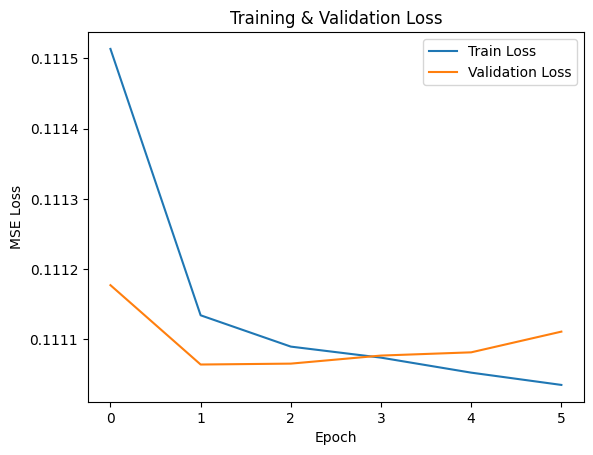

In [158]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

In [195]:
model.eval()
y_true_all, y_pred_all = [], []
x_test_all = []
test_loss = 0.0
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to('cuda'), y_test.to('cuda')
        y_pred_test = model(x_test)
        loss = criterion(y_pred_test, y_test)
        test_loss += loss.item()
        x_test_all.append(x_test.cpu().numpy())
        y_true_all.append(y_test.cpu().numpy())
        y_pred_all.append(y_pred_test.cpu().numpy())
test_loss /= len(test_loader)
test_r2, test_pearson = compute_r2_pearson(y_true_all, y_pred_all)
print(f"Test MSE Loss: {test_loss:.4f}, Test R2: {test_r2:.4f}, Test Pearson: {test_pearson:.4f}")

Test MSE Loss: 0.1112, Test R2: -0.0011, Test Pearson: -0.0001


[[1.812902  0.        0.        ... 0.        0.        1.2709123]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        1.7814181 ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]]
[[0.5181281  0.0273551  0.3859426  ... 0.00557882 0.00469549 0.27648303]
 [0.5181281  0.0273551  0.3859426  ... 0.00557882 0.00469549 0.27648303]
 [0.5181281  0.0273551  0.3859426  ... 0.00557882 0.00469549 0.27648303]
 ...
 [0.5181281  0.0273551  0.3859426  ... 0.00557882 0.00469549 0.27648303]
 [0.5181281  0.0273551  0.3859426  ... 0.00557882 0.00469549 0.27648303]
 [0.5181281  0.0273551  0.3859426  ... 0.00557882 0.00469549 0.27648303]]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


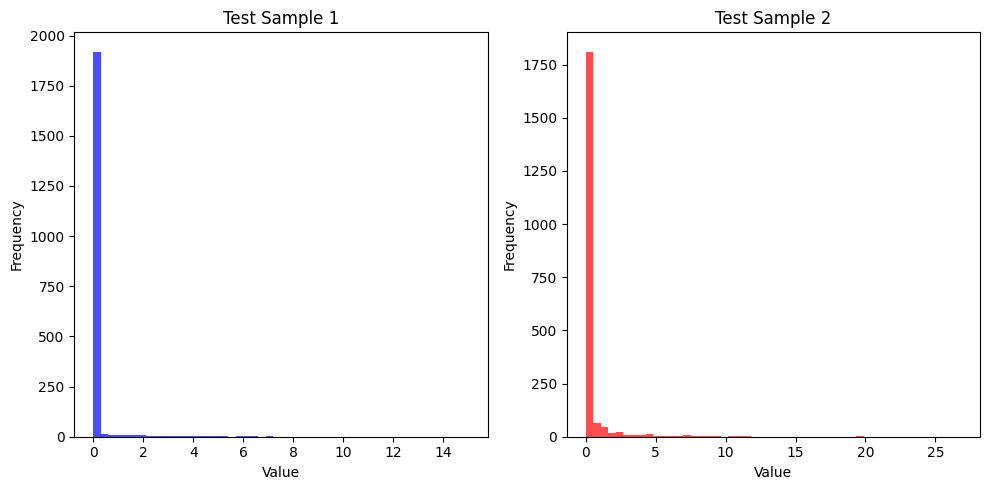

In [ ]:
# plot the two test samples as a histogram (they are embeddings)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(x_test_all[0][1].flatten(), bins=50, color='blue', alpha=0.7)
axs[0].set_title('Test Sample 1')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')
axs[1].hist(x_test_all[0][2].flatten(), bins=50, color='red', alpha=0.7)
axs[1].set_title('Test Sample 2')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

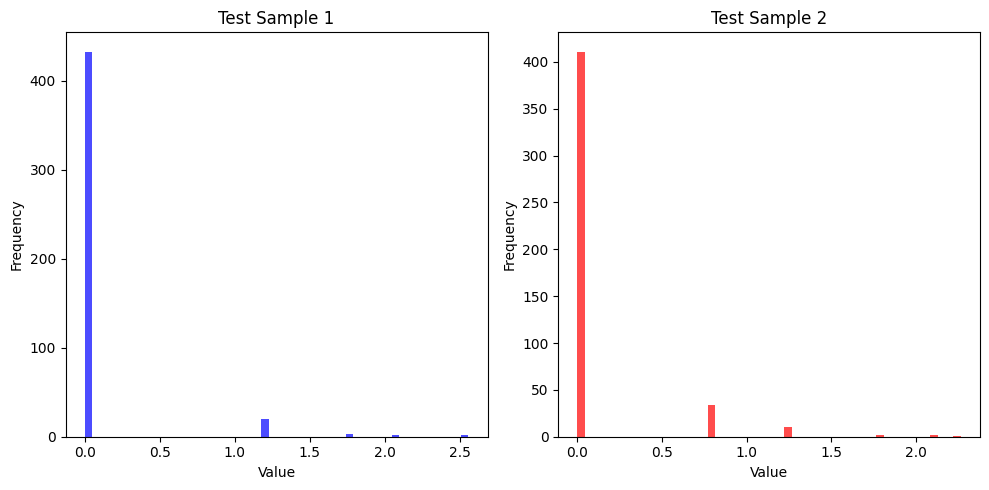

In [178]:
# plot the true expressions of two test samples
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(y_true_all[0][1].flatten(), bins=50, color='blue', alpha=0.7)
axs[0].set_title('Test Sample 1')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')
axs[1].hist(y_true_all[0][2].flatten(), bins=50, color='red', alpha=0.7)
axs[1].set_title('Test Sample 2')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

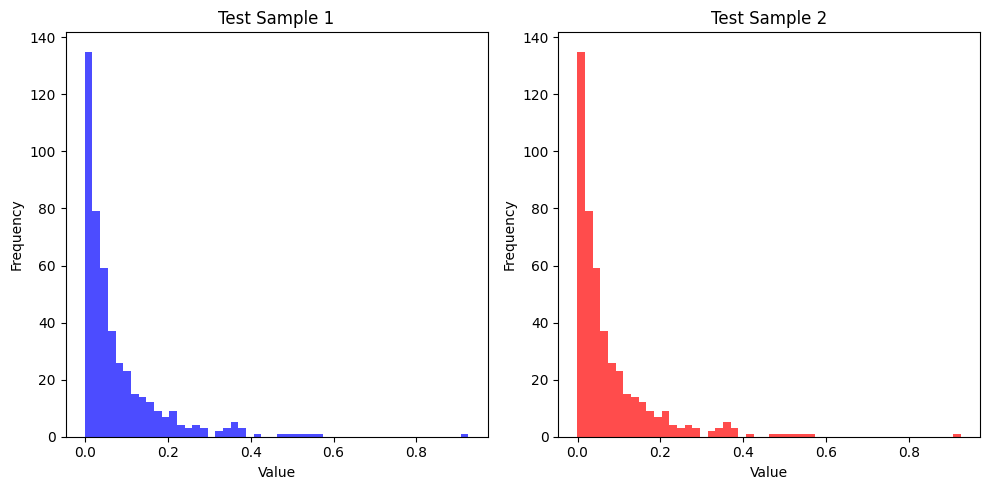

In [179]:
# plot the two predicted expressions of two test samples
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  
axs[0].hist(y_pred_all[0][1].flatten(), bins=50, color='blue', alpha=0.7)
axs[0].set_title('Test Sample 1')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')  
axs[1].hist(y_pred_all[0][2].flatten(), bins=50, color='red', alpha=0.7)
axs[1].set_title('Test Sample 2')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [197]:
pearson = []
y_pred = np.vstack(y_pred_all)
y_true = np.vstack(y_true_all)
for i in range(y_true.shape[1]):
    corr, _ = stats.pearsonr(y_true[:, i], y_pred[:, i])
    pearson.append(corr)
mean_pearson = np.nanmean(pearson)

(460,)
(22379,)
R2 of expression vector:  0.020224690437316895
Pearson of expression vector:  0.18172315
R2 of some gene:  -9.548664093017578e-05
Pearson of some gene:  0.012561899


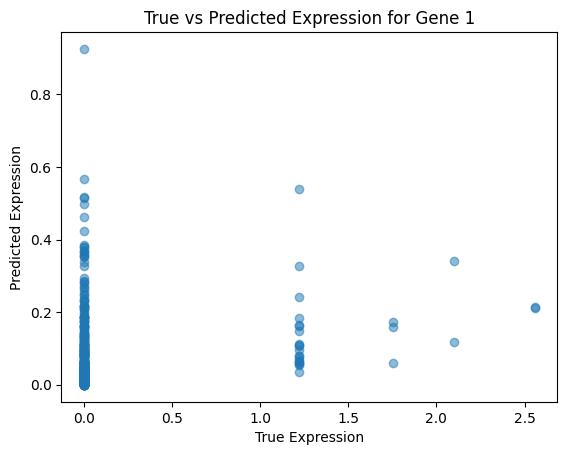

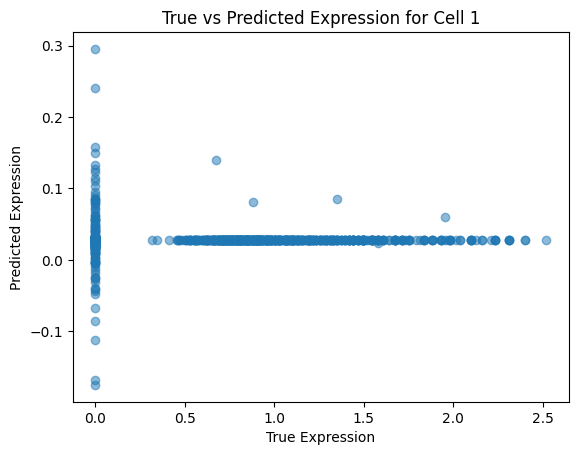

In [228]:
# print(y_pred[1,:])
print(y_true[1,:].shape)
print(y_pred[:,1].shape)

# r2 score of expression vectors
r2 = r2_score(y_true[1,:], y_pred[1,:])
p,_ = stats.pearsonr(y_true[1,:], y_pred[1,:])
print("R2 of expression vector: ", r2)
print("Pearson of expression vector: ", p)

r2 = r2_score(y_true[:,1], y_pred[:,1])
p,_ = stats.pearsonr(y_true[:,1], y_pred[:,1])
print("R2 of some gene: ", r2)
print("Pearson of some gene: ", p)

# plot the two predicted expressions of one test sample
plt.scatter(y_true[1,:], y_pred[1,:], alpha=0.5)
plt.xlabel('True Expression')
plt.ylabel('Predicted Expression')
plt.title('True vs Predicted Expression for Gene 1')
plt.show()

# plot the two predicted expressions of one test sample
plt.scatter(y_true[:,1], y_pred[:,1], alpha=0.5)
plt.xlabel('True Expression')
plt.ylabel('Predicted Expression')
plt.title('True vs Predicted Expression for Cell 1')
plt.show()

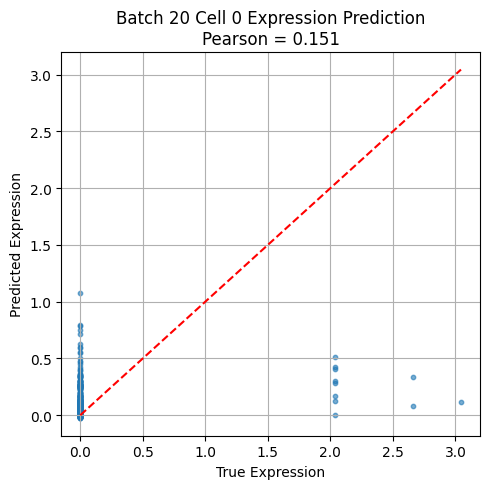

In [226]:
# Pick one cell (e.g., index 0)
batch_idx = 20
cell_idx = 0
y_true_vec = y_true_all[batch_idx][cell_idx]
y_pred_vec = y_pred_all[batch_idx][cell_idx]

# Scatter plot
plt.figure(figsize=(5, 5))
plt.scatter(y_true_vec, y_pred_vec, alpha=0.6, s=10)
plt.plot([y_true_vec.min(), y_true_vec.max()], [y_true_vec.min(), y_true_vec.max()], 'r--')
plt.xlabel("True Expression")
plt.ylabel("Predicted Expression")
plt.title(f"Batch {batch_idx} Cell {cell_idx} Expression Prediction\nPearson = {np.corrcoef(y_true_vec, y_pred_vec)[0,1]:.3f}")
plt.grid(True)
plt.tight_layout()
plt.show()

(460,)
<class 'numpy.ndarray'>


/home/b-evelyntong/hl/ac109_project/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/b-evelyntong/hl/ac109_project/.venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


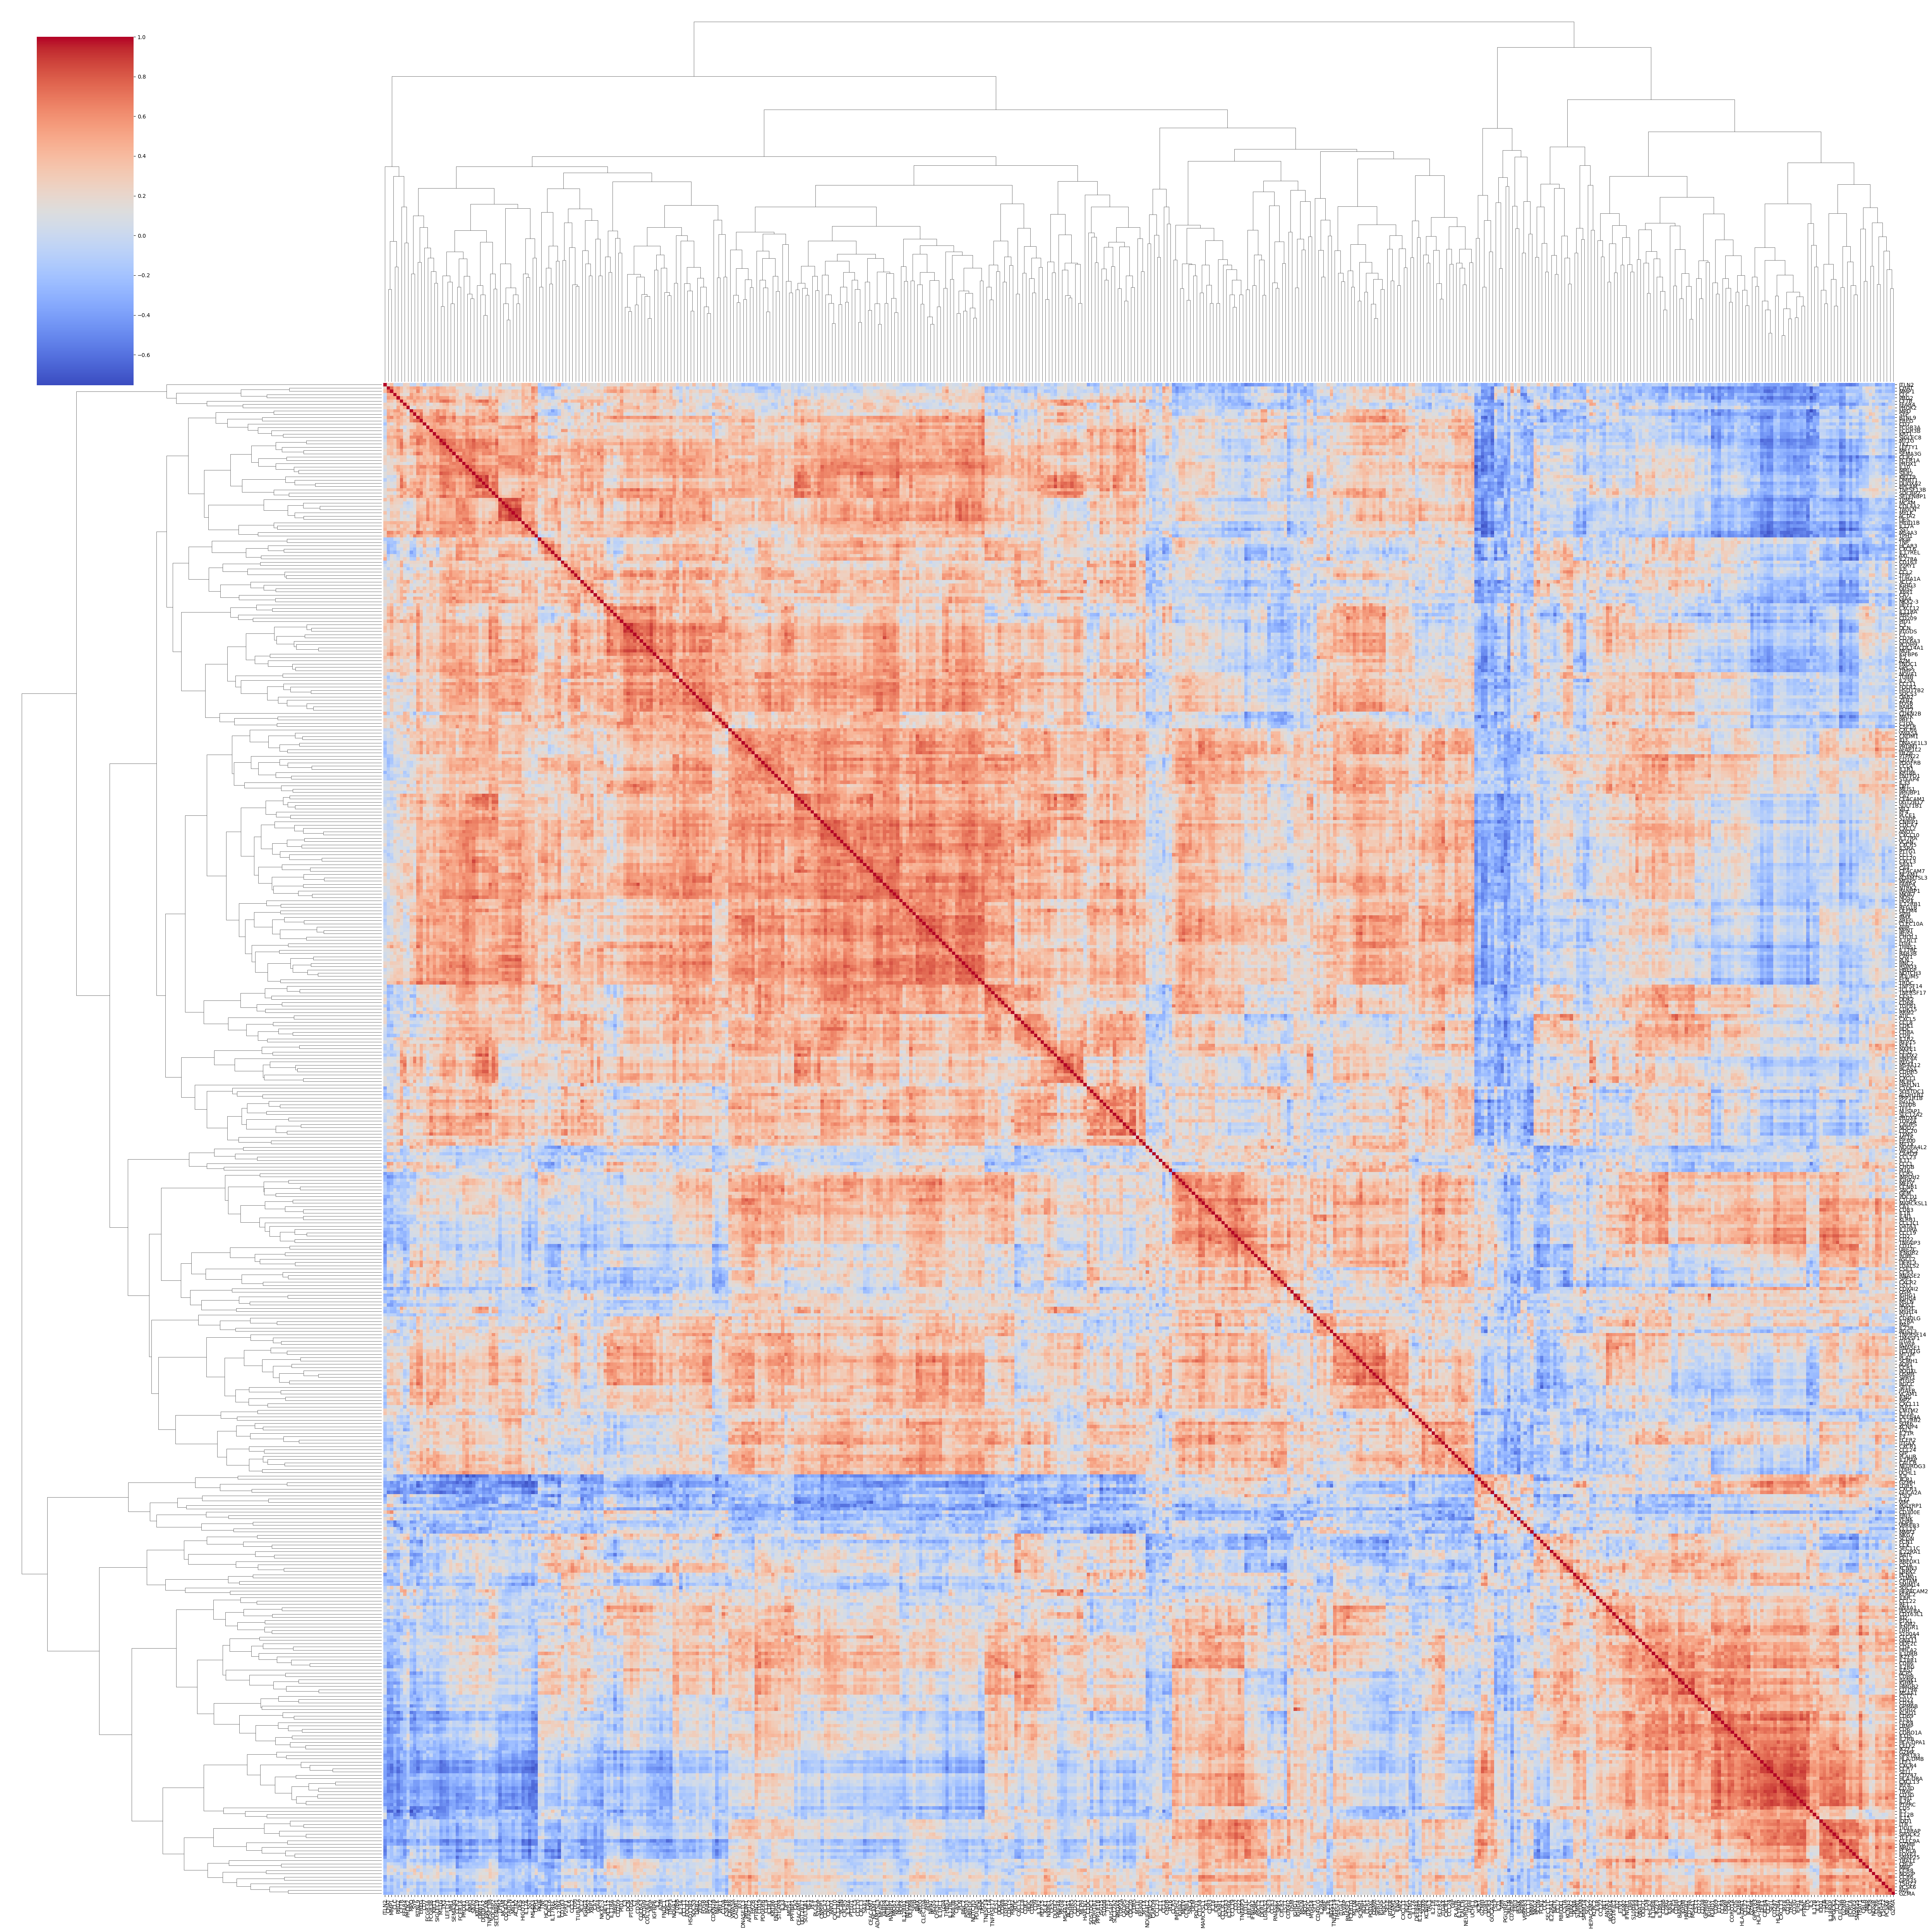

In [243]:
#can we use our prediction to make a gene heatmap??
# get the predicted expression for all cells
print(y_pred[1].shape)
print(type(y_pred))

gene_names = sdata['anucleus'].var['gene_symbols'].values
corr_matrix = np.corrcoef(y_pred.T)
# label with gene names and save a high resolution image, and enable clustering
sns.clustermap(
    corr_matrix,
    cmap='coolwarm',
    row_cluster=True,
    col_cluster=True,
    xticklabels=gene_names,
    yticklabels=gene_names,
    figsize=(50, 50)
)

plt.savefig("gene_correlation_clustermap.png", dpi=300)
plt.show()

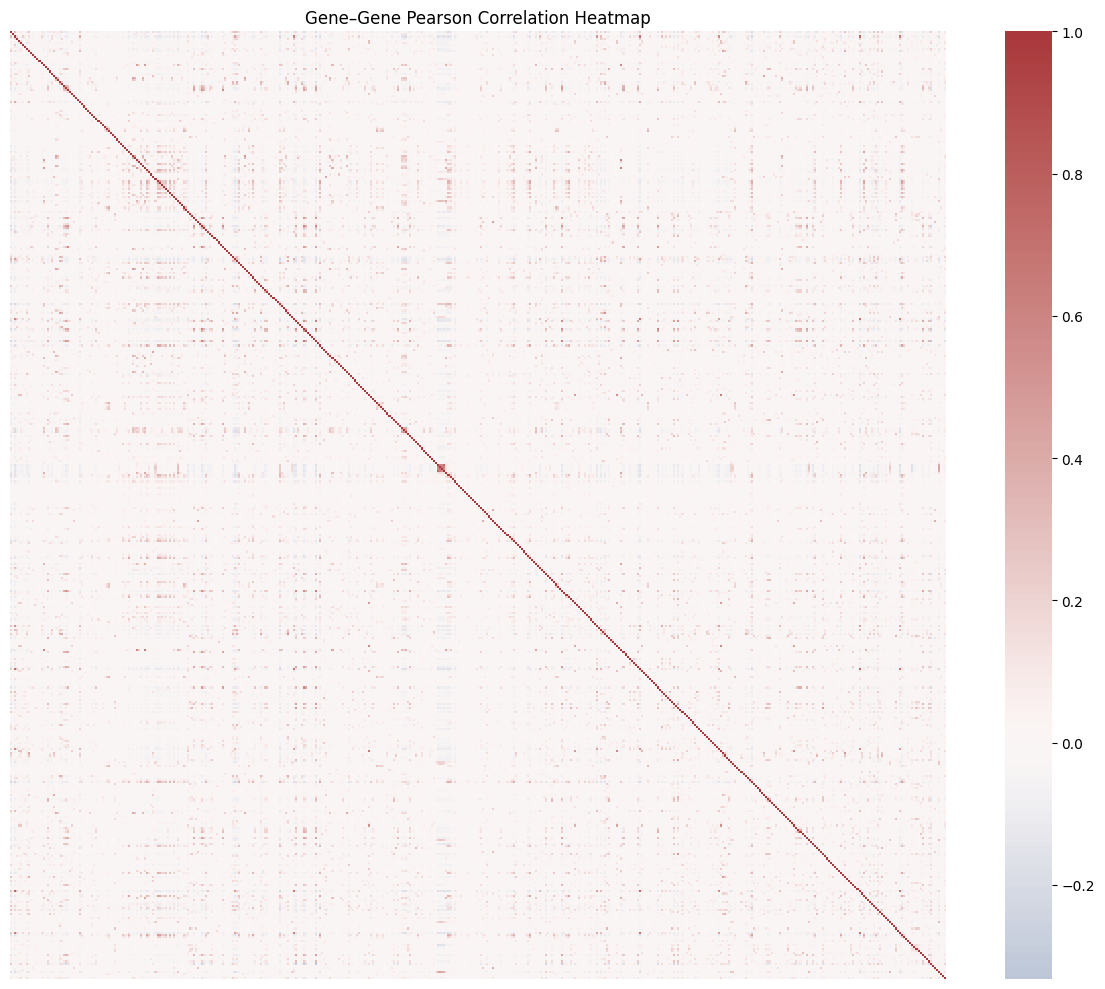

In [238]:
# now for the true expression??
corr_matrix = np.corrcoef(y_true.T)  # transpose: now shape (460, 460)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="vlag", center=0, xticklabels=False, yticklabels=False)
plt.title("Gene–Gene Pearson Correlation Heatmap")
plt.tight_layout()
plt.show()

## Citation
Broad Institute autoimmune disease. CrunchDAO Docs V3. (2024a). https://docs.crunchdao.com/competitions/competitions/broad-institute-autoimmune-disease